# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import geopandas as gpd

In [5]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.9.2
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [12]:
# Try loading one file

df = pd.read_parquet('trip_records/2023-1.parquet')
df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'trip_records/2023-1.parquet'

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [791]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

# Step 1: Define the path to the directory containing your files
directory_path = 'trip_records/'

In [19]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Step 1: Define the path to the directory containing your files
directory_path = 'trip_records/'

# Initialize an empty dataframe for the final sampled data
final_sampled_data = pd.DataFrame()

# Step 2: List the files in the directory
file_list = os.listdir(directory_path)

# Initialize an empty dataframe for the final combined data
df = pd.DataFrame()

# Initialize a dictionary to store monthly data
monthly_data = {month: pd.DataFrame() for month in range(1, 13)}

# Define start and end datetime for the year 2023
start_datetime = pd.Timestamp("2023-01-01 00:00:00")
end_datetime = pd.Timestamp("2023-12-31 23:59:59")

# Iterate through the list of files and sample one by one
for file_name in file_list:
    try:
        # File path for the current file
        file_path = os.path.join(directory_path, file_name)

        # Reading the current file
        file_data = pd.read_parquet(file_path)

        # Convert the date column to datetime if it's not already
        file_data['tpep_pickup_datetime'] = pd.to_datetime(file_data['tpep_pickup_datetime'])

        # Filter data to only include dates within the year 2023
        file_data = file_data[file_data['tpep_pickup_datetime'].between(start_datetime, end_datetime, inclusive='both')]

        # Iterate through each month and concatenate the data
        for month in range(1, 13):
            monthly_temp_data = file_data[file_data['tpep_pickup_datetime'].dt.month == month]
            monthly_data[month] = pd.concat([monthly_data[month], monthly_temp_data])

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

# Iterate through each month to sample data by hour
for month in range(1, 13):
    final_monthly_data = monthly_data[month]

    # Group by date and hour, then sample
    grouped = final_monthly_data.groupby([final_monthly_data['tpep_pickup_datetime'].dt.date, 
                                          final_monthly_data['tpep_pickup_datetime'].dt.hour])
    for (day, hour), hourly_data in grouped:
        
        # Sample 5% of the hourly data randomly
        hourly_sampled = hourly_data.sample(frac=0.05, random_state=1)
        final_sampled_data = pd.concat([final_sampled_data, hourly_sampled])

print()
print("Final sampled data size:", final_sampled_data.size)   


Final sampled data size: 291500


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [804]:
# Proportional Downsampling if Exceeding 299000 (<300000)
TARGET_MAX = 299000 

if len(final_sampled_data) > TARGET_MAX:
    print("Downsampling to maintain proper date-hour proportions...")
    
    grouped = final_sampled_data.groupby([final_sampled_data['tpep_pickup_datetime'].dt.date, 
                                          final_sampled_data['tpep_pickup_datetime'].dt.hour])
    # Calculate proportional sample size for each group
    group_sizes = grouped.size()
    total_rows = group_sizes.sum()
    downsample_frac = TARGET_MAX / total_rows  # Fraction to retain per group
    print("downsample fraction :::::", downsample_frac)
    final_sampled_data = grouped.apply(lambda x: x.sample(frac=min(1, downsample_frac), random_state=42)).reset_index(drop=True)
    print()
    print(f"After Downsampling, Final sampled dataset contains {len(final_sampled_data)} rows.", "\n")

Downsampling to maintain proper date-hour proportions...
downsample fraction ::::: 0.15766591173345496

After Downsampling, Final sampled dataset contains 299081 rows. 



In [806]:
# Store the df in csv/parquet
output_file_path = os.path.join(directory_path, 'sampled_trip_records.parquet')
final_sampled_data.to_parquet(output_file_path)

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [13]:
# Load the new data file
new_file_path = os.path.join(directory_path, 'sampled_trip_records.parquet')
new_df = pd.read_parquet(new_file_path)

In [15]:
new_df.head(5)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:38:41   2023-01-01 00:41:42              1.0   
1         2  2023-01-01 00:43:59   2023-01-01 01:13:02              2.0   
2         2  2023-01-01 00:37:44   2023-01-01 00:46:31              1.0   
3         2  2023-01-01 00:26:06   2023-01-01 00:53:30              4.0   
4         2  2023-01-01 00:37:56   2023-01-01 00:48:50              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.43         1.0                  N           114           144   
1           1.78         1.0                  N           100           143   
2           1.19         1.0                  N           107           234   
3           3.91         1.0                  N           161           148   
4           2.94         1.0                  N           137           236   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1          5.1    1.0      0.5        2.02           0.0   
1             1         23.3    1.0      0.5        7.08           0.0   
2             1         10.0    1.0      0.5        1.50           0.0   
3             1         26.8    1.0      0.5        0.00           0.0   
4             2         14.2    1.0      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  Airport_fee  \
0                    1.0         12.12                   2.5          NaN   
1                    1.0         35.38                   2.5          NaN   
2                    1.0         16.50                   2.5          NaN   
3                    1.0         31.80                   2.5          NaN   
4                    1.0         19.20                   2.5          NaN   

   airport_fee  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [17]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299081 entries, 0 to 299080
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               299081 non-null  int64         
 1   tpep_pickup_datetime   299081 non-null  datetime64[us]
 2   tpep_dropoff_datetime  299081 non-null  datetime64[us]
 3   passenger_count        289582 non-null  float64       
 4   trip_distance          299081 non-null  float64       
 5   RatecodeID             289582 non-null  float64       
 6   store_and_fwd_flag     289582 non-null  object        
 7   PULocationID           299081 non-null  int64         
 8   DOLocationID           299081 non-null  int64         
 9   payment_type           299081 non-null  int64         
 10  fare_amount            299081 non-null  float64       
 11  extra                  299081 non-null  float64       
 12  mta_tax                299081 non-null  floa

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [21]:
# Fix the index and drop any columns that are not needed
new_df.reset_index(drop=True, inplace=True)

# Drop the store_and_fwd_flag and VendorID columns as they are not required for analysis.
new_df.drop(columns=["store_and_fwd_flag"], inplace=True)

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [24]:
# Combine the two airport fee columns
new_df['combined_airport_fee'] = new_df['Airport_fee'].combine_first(new_df['airport_fee'])

# After combining the two airport fee columns, drop the Airport_fee and airport_fee columns.
new_df.drop(columns=["Airport_fee", "airport_fee"], inplace=True)

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [27]:
# check where values of fare amount are negative
fare_amount_containing_negative_value = new_df[new_df["fare_amount"] < 0]
print("Negative Fare Amount DF ::::: ",fare_amount_containing_negative_value)

Negative Fare Amount DF :::::  Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, combined_airport_fee]
Index: []


After analysis, it is concluded that the values in the fare_amount column are not negative.

Did you notice something different in the `RatecodeID` column for above records?

In [31]:
# Analyse RatecodeID for the negative fare amounts

fare_amount_containing_negative_value['RatecodeID'].value_counts()

Series([], Name: count, dtype: int64)

After analysis, it is concluded that the values in the fare_amount column are not negative. 
Therefore, there is no need to analyze the RatecodeID column for negative values.

In [34]:
# Find which columns have negative values

# To measure the total travel time of each trip and identify invalid trips (e.g., trips with negative duration due to incorrect timestamps), 
# Create the trip_duration column that contains values in minutes.
new_df['trip_duration'] = (new_df['tpep_dropoff_datetime'] - new_df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Create the pickup_hour and pickup_day_of_week columns containing values in hours and day names, respectively.
new_df['pickup_hour'] = new_df['tpep_pickup_datetime'].dt.hour
new_df['pickup_day_of_week'] = new_df['tpep_pickup_datetime'].dt.day_name()

# Function to check which columns have negative values
def find_columns_containing_negative_values(df):
    """Find the columns that contain negative values in the DataFrame.

    Args:
        df: Pandas DataFrame to check for negative values.

    Returns:
        List of column names that contain negative values.
    """
    if df.select_dtypes(include=[np.number]).empty:
        return []

    return [col for col in df.select_dtypes(include=[np.number]).columns if (df[col] < 0).any()]

columns_with_negatives = find_columns_containing_negative_values(new_df)
print("Columns containing negative values :::: ",columns_with_negatives)

Columns containing negative values ::::  ['extra', 'mta_tax', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'combined_airport_fee', 'trip_duration']


In [36]:
# fix these negative values

In [38]:
print("No of Disputed trips :::", new_df[(new_df['total_amount'] < 0) & (new_df["payment_type"] == 4)].shape[0])
print("No of Non-Disputed trips :::", new_df[(new_df['total_amount'] < 0) & (new_df["payment_type"] != 4)].shape[0])

new_df = new_df[new_df['total_amount'] >= 0]

No of Disputed trips ::: 1
No of Non-Disputed trips ::: 16


Since there are 93 rows with negative total_amount, including 2 for disputed trips and the remaining for non-disputed trips, removing rows where total_amount < 0 for all payment_type cases will not significantly impact the analysis.

A negative trip_duration occurs when the pickup time is later than the drop-off time, which is not possible in a valid trip. Therefore, drop entries where trip_duration < 0.0.

In [42]:
new_df = new_df[new_df["trip_duration"] >= 0.0]

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [46]:
# Find the proportion of missing values in each column
length = len(new_df)
missing_values_proportion = new_df.isnull().sum() / length * 100
print(missing_values_proportion)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.174396
trip_distance            0.000000
RatecodeID               3.174396
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.174396
combined_airport_fee     3.174396
trip_duration            0.000000
pickup_hour              0.000000
pickup_day_of_week       0.000000
dtype: float64


**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [49]:
# Display the rows with null values
print(new_df[new_df["passenger_count"].isnull()])

# Impute NaN values in 'passenger_count'
new_df = new_df[~(new_df["passenger_count"].isnull())]

        VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
9              2  2023-01-01 00:54:00   2023-01-01 01:10:00              NaN   
40             2  2023-01-01 00:39:21   2023-01-01 01:00:12              NaN   
42             2  2023-01-01 01:36:00   2023-01-01 01:38:00              NaN   
44             2  2023-01-01 01:02:23   2023-01-01 01:14:26              NaN   
56             2  2023-01-01 01:35:00   2023-01-01 01:50:00              NaN   
...          ...                  ...                   ...              ...   
299045         1  2023-12-31 22:58:20   2023-12-31 23:20:56              NaN   
299046         2  2023-12-31 22:57:07   2023-12-31 23:21:41              NaN   
299052         2  2023-12-31 23:38:22   2024-01-01 00:02:48              NaN   
299054         2  2023-12-31 23:28:20   2023-12-31 23:33:05              NaN   
299074         1  2023-12-31 23:13:30   2023-12-31 23:27:19              NaN   

        trip_distance  RatecodeID  PULo

All entries where passenger_count is null also have RatecodeID, congestion_surcharge, and combined_airport_fee as null. For these entries, the payment_type is 0, which is not a valid category based on the defined payment types. The presence of multiple missing fields in these rows suggests data corruption or invalid transactions. These rows account for 3% of the dataset, and removing them will not significantly impact the analysis.

Did you find zeroes in passenger_count? Handle these.

In [53]:
new_df[new_df['passenger_count'] == 0.0]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
197            1  2023-01-01 07:01:13   2023-01-01 07:26:32              0.0   
334            1  2023-01-01 14:22:03   2023-01-01 14:33:31              0.0   
437            1  2023-01-01 17:53:35   2023-01-01 18:04:20              0.0   
471            1  2023-01-01 18:41:42   2023-01-01 19:06:15              0.0   
480            1  2023-01-01 18:35:28   2023-01-01 18:52:49              0.0   
...          ...                  ...                   ...              ...   
298841         1  2023-12-31 17:37:35   2023-12-31 17:47:38              0.0   
298897         1  2023-12-31 19:33:46   2023-12-31 19:51:37              0.0   
298900         1  2023-12-31 19:11:37   2023-12-31 19:57:06              0.0   
298973         1  2023-12-31 20:59:26   2023-12-31 21:22:04              0.0   
299056         1  2023-12-31 23:06:18   2023-12-31 23:25:09              0.0   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
197              12.9         2.0           132           148             1   
334               2.2         1.0           164            79             1   
437               1.7         1.0           144           234             1   
471               1.4         1.0           230           186             1   
480              10.8         1.0           138           136             2   
...               ...         ...           ...           ...           ...   
298841            2.2         1.0           142           236             1   
298897            6.1         1.0           107            52             1   
298900           18.5         2.0           132           142             2   
298973           12.3         1.0           170           134             1   
299056            2.0         1.0           246           143             2   

        fare_amount  ...  mta_tax  tip_amount  tolls_amount  \
197            70.0  ...      0.5       15.05          0.00   
334            13.5  ...      0.5        0.00          0.00   
437            12.1  ...      0.5        3.90          0.00   
471            16.3  ...      0.5        0.00          0.00   
480            41.5  ...      0.5        0.00          6.55   
...             ...  ...      ...         ...           ...   
298841         12.8  ...      0.5        2.00          0.00   
298897         26.8  ...      0.5        6.16          0.00   
298900         70.0  ...      0.5        0.00          0.00   
298973         49.2  ...      0.5       13.60         13.88   
299056         18.4  ...      0.5        0.00          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
197                       1.0         90.30                   2.5   
334                       1.0         17.50                   2.5   
437                       1.0         20.00                   2.5   
471                       1.0         20.30                   2.5   
480                       1.0         55.80                   0.0   
...                       ...           ...                   ...   
298841                    1.0         18.80                   2.5   
298897                    1.0         36.96                   2.5   
298900                    1.0         75.75                   2.5   
298973                    1.0         81.68                   2.5   
299056                    1.0         23.40                   2.5   

        combined_airport_fee  trip_duration  pickup_hour  pickup_day_of_week  
197                     1.25      25.316667            7              Sunday  
334                     0.00      11.466667           14              Sunday  
437                     0.00      10.750000           17              Sunday  
471                     0.00      24.550000           18              Sunday  
480                     1.25      17.350000           18              Sunday  
...                      ...          

The query new_df[new_df['passenger_count'] == 0.0] returns 4591 entries. To decide whether these entries can be removed, it is necessary to check the proportion of these entries relative to the total dataset.

In [56]:
length = len(new_df)
zero_proportion = (new_df["passenger_count"].eq(0).sum() / len(new_df)) * 100
print(f"Propotion of zero values in passenger_count is = ",zero_proportion)

new_df = new_df[~(new_df["passenger_count"] == 0)]

Propotion of zero values in passenger_count is =  1.5855309508350717


Entries with passenger_count = 0 account for 1.5% of the dataset, which is a small proportion. 

Since a trip must have at least one passenger, a value of zero is logically incorrect. 

To maintain data integrity, the most appropriate action is to remove these entries, as their low occurrence will not significantly impact the analysis.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

Missing values in RatecodeID were handled alongside passenger_count missing values, as all entries with missing passenger_count also had null RatecodeID, congestion_surcharge, and combined_airport_fee. Since these rows also had payment_type = 0 (an invalid category), they were removed to maintain data integrity.

Analyzing RatecodeID further to verify whether all values align with the definitions provided in the data dictionary.

In [61]:
print(new_df['RatecodeID'].value_counts())

RatecodeID
1.0     268949
2.0      11234
99.0      1634
5.0       1577
3.0        996
4.0        575
Name: count, dtype: int64


In [63]:
ratecodeid_99_proportion = (new_df["RatecodeID"].eq(99).sum() / len(new_df)) * 100
print(f"Propotion of 99 in RatecodeID is = ",ratecodeid_99_proportion)

new_df = new_df[~(new_df['RatecodeID'] == 99)]

Propotion of 99 in RatecodeID is =  0.5734037513378836


Entries with RatecodeID = 99 account for 0.58% of the dataset. Since 99 is not a valid category and these entries may indicate incorrect or missing data, removing them is the most appropriate action to maintain data quality.

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [67]:
# handle null values in congestion_surcharge

Missing values in congestion_surcharge were handled alongside passenger_count missing values, as all entries with missing passenger_count also had null RatecodeID, congestion_surcharge, and combined_airport_fee. Since these rows also had payment_type = 0 (an invalid category), they were removed to maintain data integrity.


Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [71]:
# Handle any remaining missing values
# Find the proportion of missing values in each column again
length = len(new_df)
missing_values_proportion = new_df.isnull().sum() / length * 100
print(missing_values_proportion)

VendorID                 0.0
tpep_pickup_datetime     0.0
tpep_dropoff_datetime    0.0
passenger_count          0.0
trip_distance            0.0
RatecodeID               0.0
PULocationID             0.0
DOLocationID             0.0
payment_type             0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.0
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.0
total_amount             0.0
congestion_surcharge     0.0
combined_airport_fee     0.0
trip_duration            0.0
pickup_hour              0.0
pickup_day_of_week       0.0
dtype: float64


Based on the missing values analysis, all columns now have 0% missing values, indicating that missing data has been successfully handled. No further action is required for missing values in the dataset.

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [76]:
# Describe the data and check if there are any potential outliers present
print(new_df.describe(include='all'))  # Includes both numerical and categorical columns

             VendorID        tpep_pickup_datetime       tpep_dropoff_datetime  \
count   283331.000000                      283331                      283331   
unique            NaN                         NaN                         NaN   
top               NaN                         NaN                         NaN   
freq              NaN                         NaN                         NaN   
mean         1.755671  2023-07-01 23:07:49.910451  2023-07-01 23:25:10.433574   
min          1.000000         2023-01-01 00:07:51         2023-01-01 00:13:33   
25%          2.000000  2023-04-01 21:01:42.500000  2023-04-01 21:17:56.500000   
50%          2.000000         2023-06-26 10:10:54         2023-06-26 10:29:32   
75%          2.000000         2023-10-05 20:38:28  2023-10-05 20:50:06.500000   
max          2.000000         2023-12-31 23:59:57         2024-01-01 00:13:09   
std          0.429689                         NaN                         NaN   

        passenger_count  tr

To identify columns that can be considered for outliers in the dataset, we should focus on numerical columns (non-fixed columns) that are likely to have extreme values or anomalies.


Outliers in trip_distance:
(2827, 21)

Outliers in fare_amount:
(2797, 21)

Outliers in tip_amount:
(2832, 21)

Outliers in tolls_amount:
(1590, 21)

Outliers in total_amount:
(2753, 21)



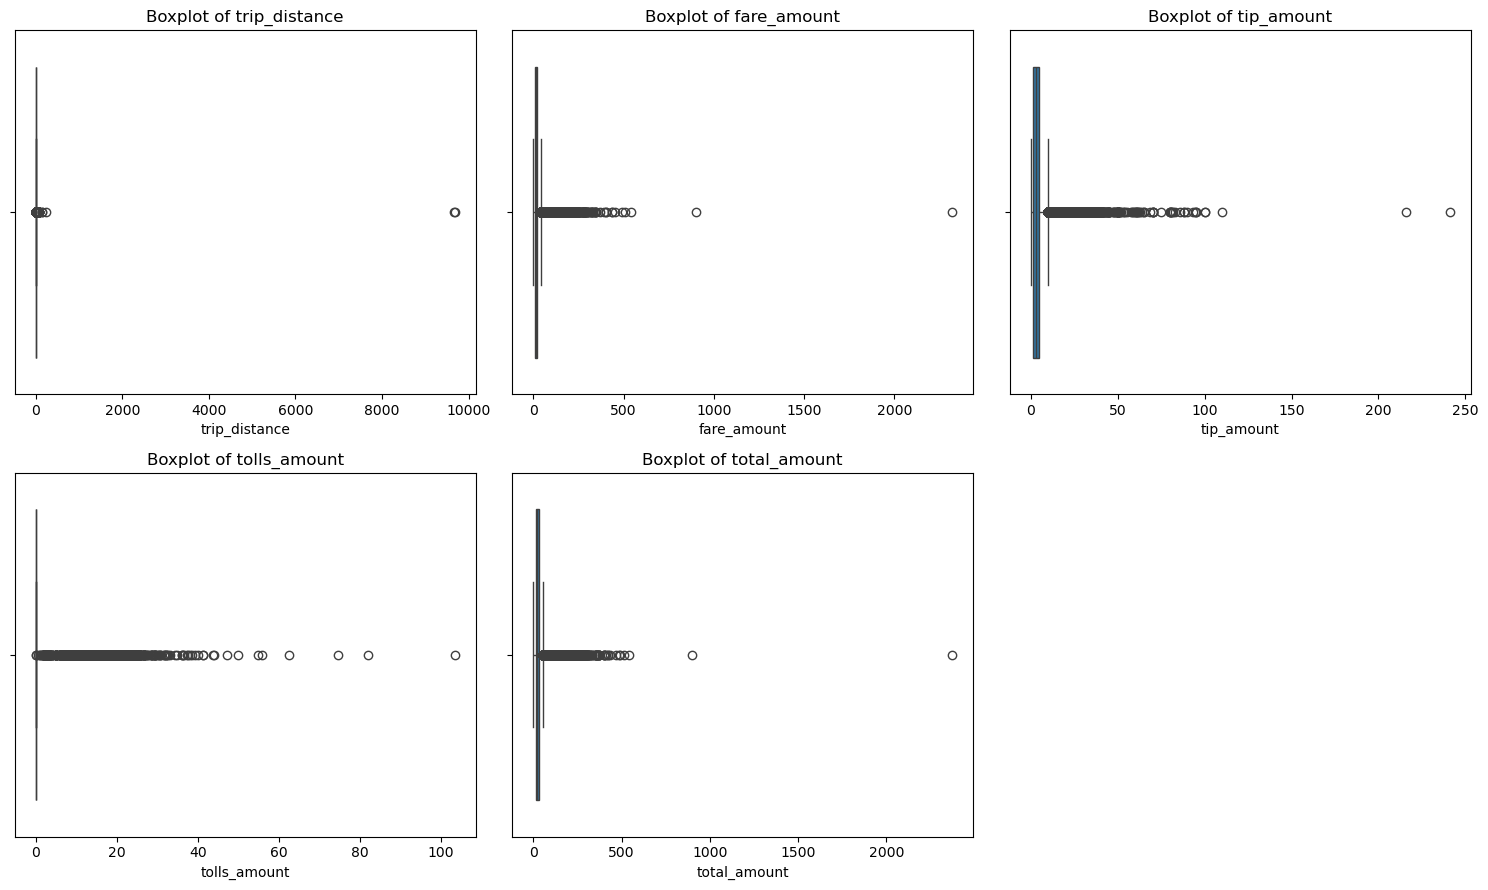

In [79]:
# Check if there are any potential outliers present using box plot
columns_to_check = ['trip_distance', 
                    'fare_amount', 
                    'tip_amount', 
                    'tolls_amount', 
                    'total_amount']


outliers = {}
for column in columns_to_check:
    cap = new_df[column].quantile(0.99)
    outliers[column] = new_df[(new_df[column] > cap)]

# Display outliers
for column, outlier_df in outliers.items():
    print(f"\nOutliers in {column}:")
    print(outlier_df.shape)

print()
num_cols = len(columns_to_check)
rows = math.ceil(num_cols / 3)  # Adjust rows based on the number of columns
plt.figure(figsize=(15, 9))  
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(rows, 3, i)  
    sns.boxplot(x=new_df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

Based on the boxplot, The dataset contains many extreme values, and none of the distributions are normal.

Check passenger_count, RatecodeID, and payment_type for any values that seem unusual based on domain knowledge (e.g., unexpected values or proportions). Verify the unique values in the categorical columns.

In [82]:
# Check for potential out of place values in various columns
print("RatecodeID :::::",new_df['RatecodeID'].unique())  # Should be in {1,2,3,4,5,6}
print("payment_type ::::",new_df['payment_type'].unique())  # Should be in {1,2,3,4,5,6}
print("passenger_count ::: ",new_df['passenger_count'].unique())  # Should be in {1,2,3,4,5,6}

RatecodeID ::::: [1. 5. 2. 3. 4.]
payment_type :::: [1 2 3 4]
passenger_count :::  [1. 2. 4. 3. 6. 5. 8. 7.]


The value 0 in the payment_type column seems unusual and might be an out-of-place value.

According to the regulations https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page
The passenger count should generally be between 1 and 6. Any value outside this range may be considered unusual.

The RatecodeID should generally be between 1 and 6. Any value outside this range may be considered unusual.

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [89]:
# remove passenger_count > 6
new_df = new_df[~(new_df['passenger_count'] > 6)]

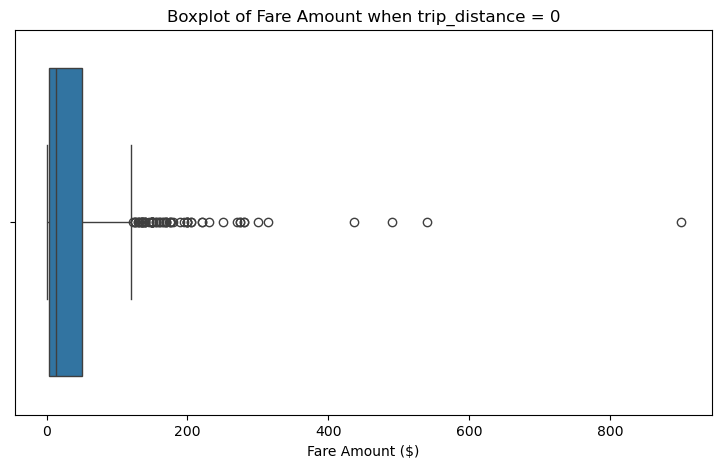

In [91]:
# Continue with outlier handling
# Handling outliers where `trip_distance` is nearly 0 and `fare_amount` is more than 300

# boxplot for fare_amount when trip_distance == 0
plt.figure(figsize=(9, 5))
sns.boxplot(data=new_df[new_df['trip_distance'] == 0], x='fare_amount')

plt.title("Boxplot of Fare Amount when trip_distance = 0")
plt.xlabel("Fare Amount ($)")
plt.show()

Based on the above analysis, it seems that some of the outliers for trip_distance being 0 and fare_amount being more than 300 are present due to errors in registering the trips.

In [94]:
# Remove these entries from the dataset
new_df = new_df[~((new_df['trip_distance'] == 0) & (new_df['fare_amount'] > 300))]

print("Boxplot for fare_amount when trip_distance = 0 after removing outliers.")
plt.figure(figsize=(9, 5))
sns.boxplot(data=new_df[new_df['trip_distance'] == 0], x='fare_amount')

plt.title("Boxplot of Fare Amount when trip_distance = 0")
plt.xlabel("Fare Amount ($)")
plt.show()

Boxplot for fare_amount when trip_distance = 0 after removing outliers.


Entries where trip_distance and fare_amount are both zero, but the pickup and dropoff zones are different, indicate data inconsistencies or errors. After analysis, it was found that there are a few such entries. 

In [97]:
# Continue with outlier handling
# Remove those entries from the main dataset to ensure the integrity of the dataset. 
inconsistent_data = new_df[((new_df['trip_distance'] == 0) & 
                  (new_df['fare_amount'] == 0) & 
                  (new_df['PULocationID'] != new_df['DOLocationID']))]

print(f"Total inconsistent entries: {len(inconsistent_data)}")

new_df = new_df[~((new_df['trip_distance'] == 0) & 
                  (new_df['fare_amount'] == 0) & 
                  (new_df['PULocationID'] != new_df['DOLocationID']))]

Total inconsistent entries: 14


Before removing entries having trip_distance > 250
trip_distance
count     283310.00
mean           3.51
std           26.10
min            0.00
25%            1.06
50%            1.77
75%            3.34
max         9676.91
median         1.77
Name: trip_distance, dtype: object


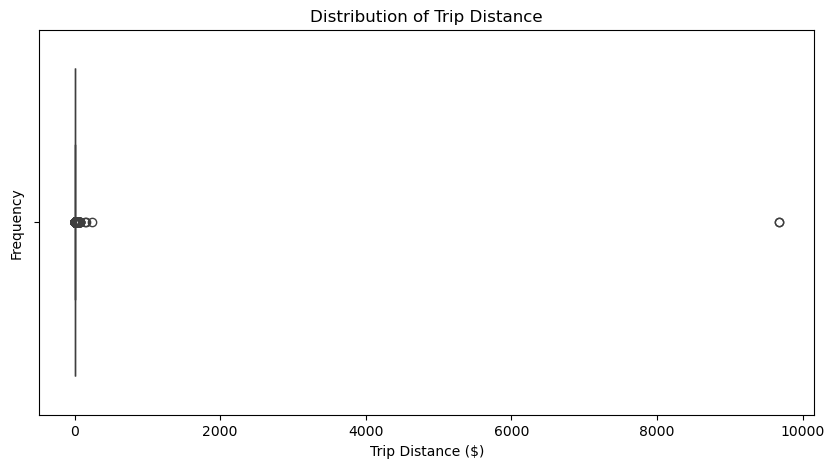


After removing entries having trip_distance > 250 



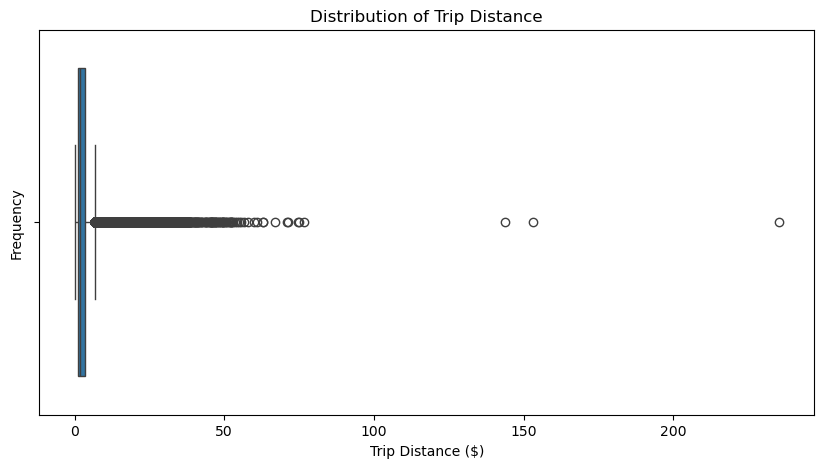

In [99]:
# Continue with outlier handling
# Entries where `trip_distance` is more than 250  miles.
print("Before removing entries having trip_distance > 250")
trip_distance_info = new_df["trip_distance"].describe().apply(lambda x: f"{x:.2f}")
median = new_df['trip_distance'].median()
trip_distance_info.loc['median'] = median
print("trip_distance")
print(trip_distance_info)

plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='trip_distance')
plt.xlabel("Trip Distance ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Trip Distance")
plt.show()

# After analysis, it seems that trip_distance greater than 250 miles can be considered outliers because:
# The median (1.8 miles) and 75th percentile (3.4 miles) are far below 250 miles.
# Only 56 out of 283310.00 trips fall into this category (~0.01976% of the total data).
# Some extreme values (e.g., 205,544 miles) appear to be clear data errors.
# Therefore, these outliers have been removed from the main dataset. 
new_df = new_df[~(new_df["trip_distance"] > 250)]

print()
print("After removing entries having trip_distance > 250", "\n")
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='trip_distance')
plt.xlabel("Trip Distance ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Trip Distance")
plt.show()

In [100]:
# Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)
new_df[(new_df["payment_type"] == 0)]

# Count and proportion of rows with payment_type = 0
count_payment_type_0 = len(new_df[new_df["payment_type"] == 0])
proportion_payment_type_0 = count_payment_type_0 / len(new_df)
print("Proportion of entries with payment_type = 0:", proportion_payment_type_0 * 100)

Proportion of entries with payment_type = 0: 0.0


Since there are no entries with payment_type = 0, no further action is required to handle this case.

In [104]:
def handle_outliers(df, column_name, quantile=0.99, cap=True):
    """
    A general method to handle outliers in a specified column.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    column_name (str): The column name to handle outliers for.
    quantile (float): The quantile value to determine the cap for outliers (default is 0.99).
    cap (bool): Whether to apply capping to outliers (default is True).
    
    Returns:
    df (DataFrame): The DataFrame with handled outliers.
    """
    
    # Calculate the cap value based on the specified quantile
    outlier_cap = df[column_name].quantile(quantile)
    print(f"{column_name} cap ::: {outlier_cap}")

    # Plotting the boxplot before handling outliers
    print(f"Box plot for {column_name} before handling outliers")
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=column_name)
    plt.xlabel(f"{column_name} ($)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column_name}")
    plt.show()

    # Print summary statistics for the column
    print(f"{column_name} Describe()")
    summary_stats = df[column_name].describe()
    summary_stats['median'] = df[column_name].median()
    print(summary_stats, "\n")

    # Apply capping if needed
    if cap:
        df[column_name] = np.where(df[column_name] > outlier_cap, outlier_cap, df[column_name])

    # Plotting the boxplot after handling outliers
    print(f"Box plot for {column_name} after handling outliers")
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x=column_name)
    plt.xlabel(f"{column_name} ($)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {column_name}")
    plt.show()

    return df

trip_distance cap ::: 20.27
Box plot for trip_distance before handling outliers


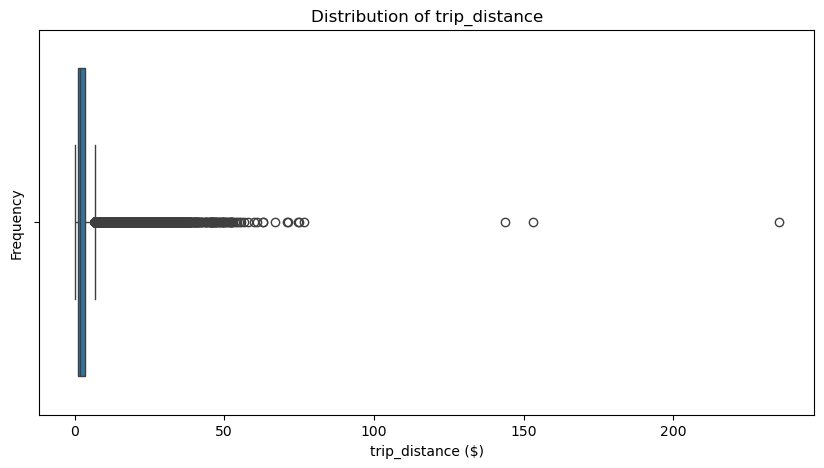

trip_distance Describe()
count     283308.000000
mean           3.438960
std            4.556378
min            0.000000
25%            1.060000
50%            1.770000
75%            3.340000
max          235.360000
median         1.770000
Name: trip_distance, dtype: float64 

Box plot for trip_distance after handling outliers


fare_per_mile cap ::: 22.352941176470587
Box plot for fare_per_mile before handling outliers


fare_per_mile Describe()
count     283278.000000
mean          11.453995
std          136.901762
min            0.000000
25%            5.620690
50%            7.142857
75%            9.027778
max        12515.000000
median         7.142857
Name: fare_per_mile, dtype: float64 

Box plot for fare_per_mile after handling outliers


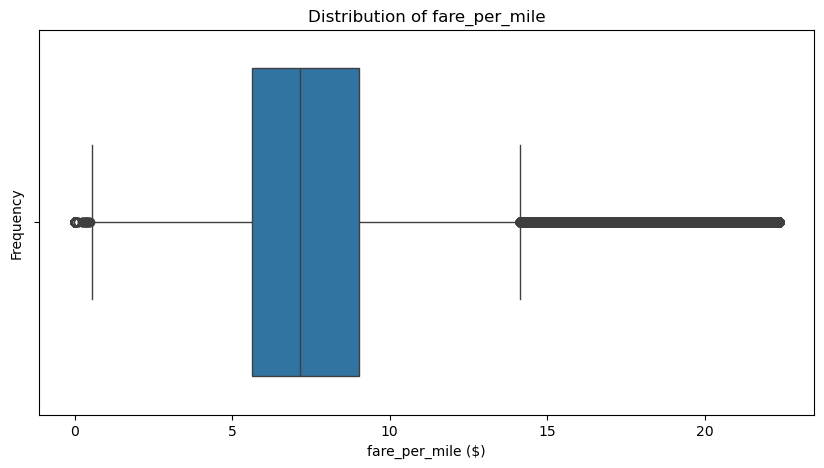

fare_amount cap ::: 73.7
Box plot for fare_amount before handling outliers


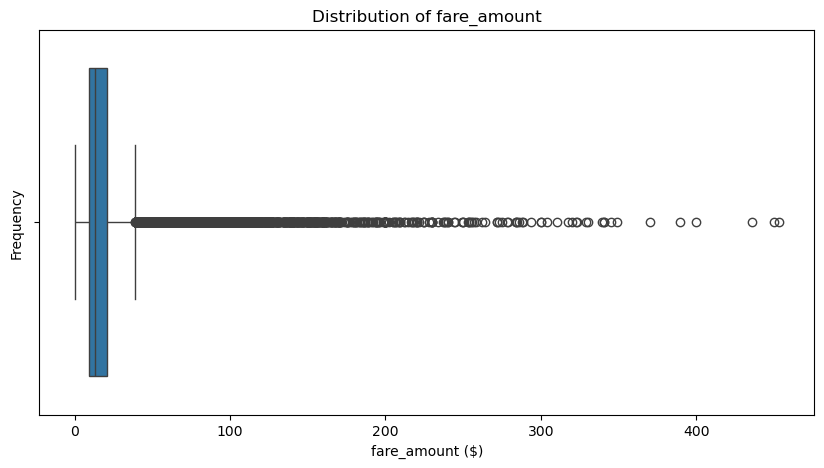

fare_amount Describe()
count     283278.000000
mean          19.274388
std           17.796033
min            0.000000
25%            9.300000
50%           13.500000
75%           21.200000
max          453.094118
median        13.500000
Name: fare_amount, dtype: float64 

Box plot for fare_amount after handling outliers


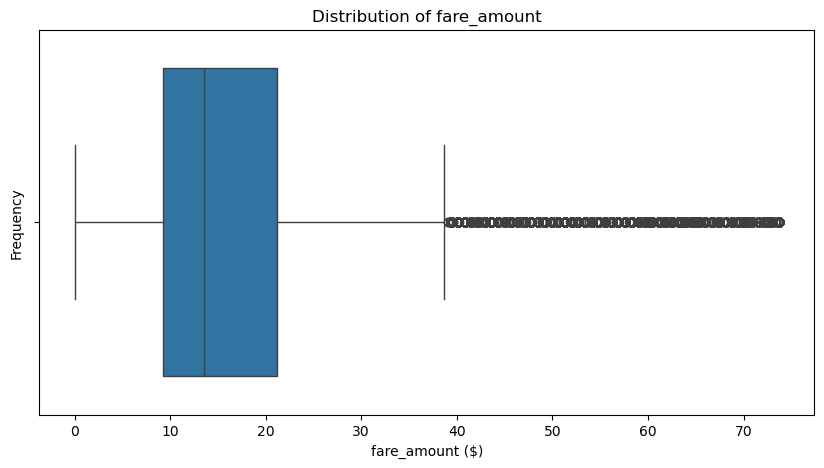

In [106]:
# Handling outliers for fare_amount trip_distance and fare_per_mile

# trip_distance outlier handling
new_df = handle_outliers(new_df, "trip_distance", quantile=0.99, cap=True)

# Recalculating fare_per_mile
new_df["fare_per_mile"] = new_df["fare_amount"] / new_df["trip_distance"]

# Handling null values in fare_per_mile
new_df = new_df[~(new_df["fare_per_mile"].isnull())]

# Replacing infinite values with zero in fare_per_mile
new_df["fare_per_mile"] = new_df["fare_per_mile"].replace([np.inf, -np.inf, np.nan], 0)  # Replace any infinities or NaN with 0 or another placeholder value

# fare_per_mile outlier handling
new_df = handle_outliers(new_df, "fare_per_mile", quantile=0.99, cap=True)

# Recalculating fare_amount
new_df["fare_amount"] = new_df["fare_per_mile"] * new_df["trip_distance"]

# fare_amount outlier handling
new_df = handle_outliers(new_df, "fare_amount", quantile=0.99, cap=True)

tolls_amount cap ::: 6.94
Box plot for tolls_amount before handling outliers


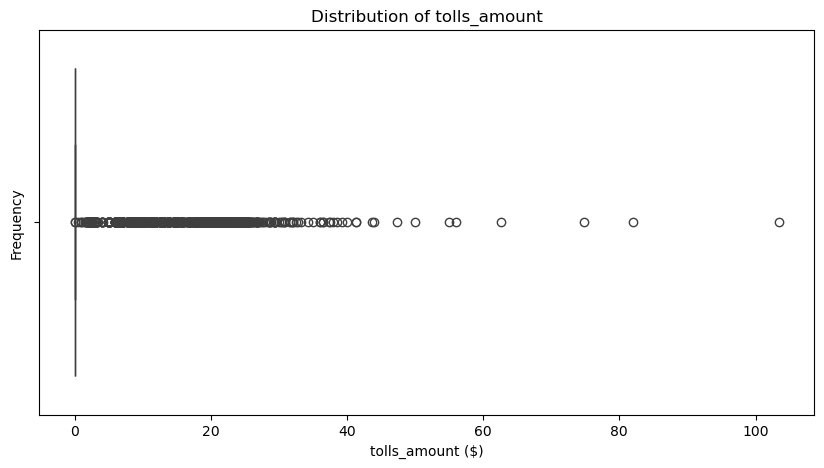

tolls_amount Describe()
count     283278.000000
mean           0.597445
std            2.192457
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max          103.450000
median         0.000000
Name: tolls_amount, dtype: float64 

Box plot for tolls_amount after handling outliers


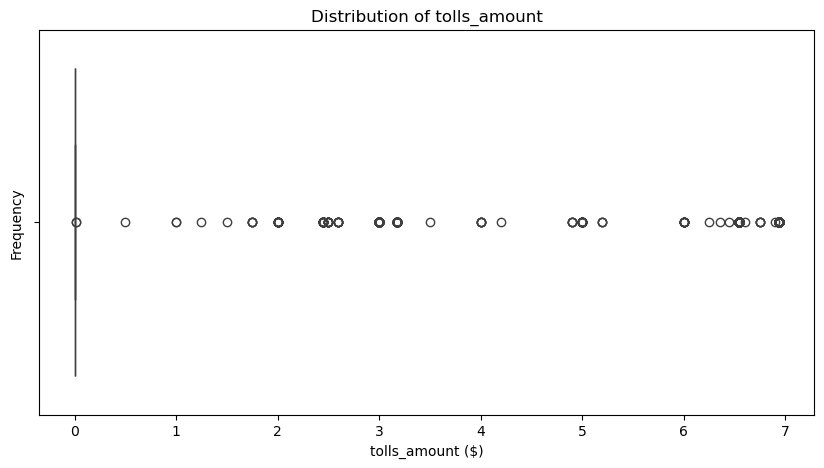

In [107]:
# tolls_amount outlier handling
new_df = handle_outliers(new_df, "tolls_amount", quantile=0.99, cap=True)

tip_amount cap ::: 17.91
Box plot for tip_amount before handling outliers


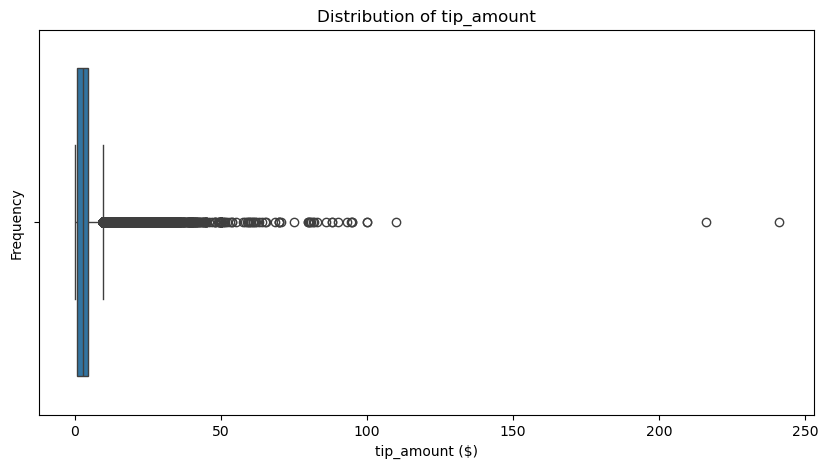

tip_amount Describe()
count     283278.000000
mean           3.605175
std            4.088292
min            0.000000
25%            1.000000
50%            2.860000
75%            4.470000
max          241.000000
median         2.860000
Name: tip_amount, dtype: float64 

Box plot for tip_amount after handling outliers


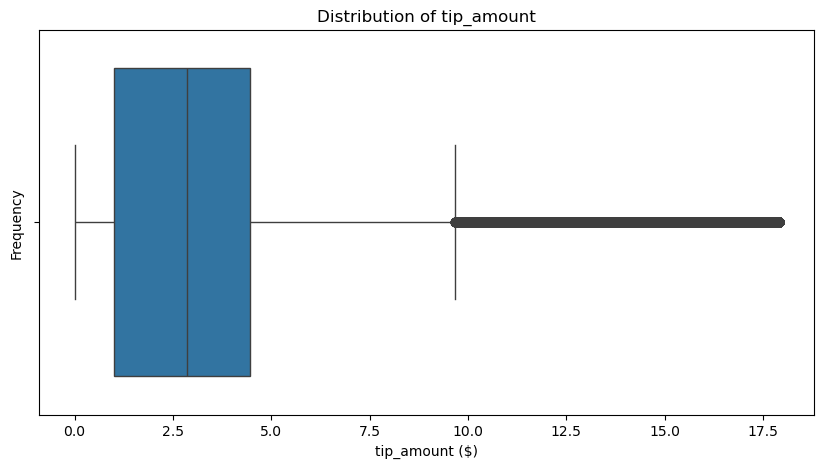

In [108]:
# tip_amount outlier handling
new_df = handle_outliers(new_df, "tip_amount", quantile=0.99, cap=True)

extra cap ::: 7.5
Box plot for extra before handling outliers


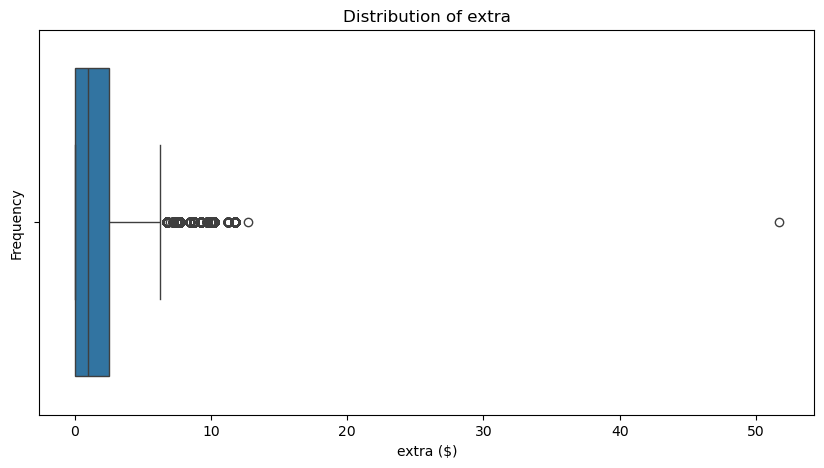

extra Describe()
count     283278.000000
mean           1.618382
std            1.832812
min            0.000000
25%            0.000000
50%            1.000000
75%            2.500000
max           51.680000
median         1.000000
Name: extra, dtype: float64 

Box plot for extra after handling outliers


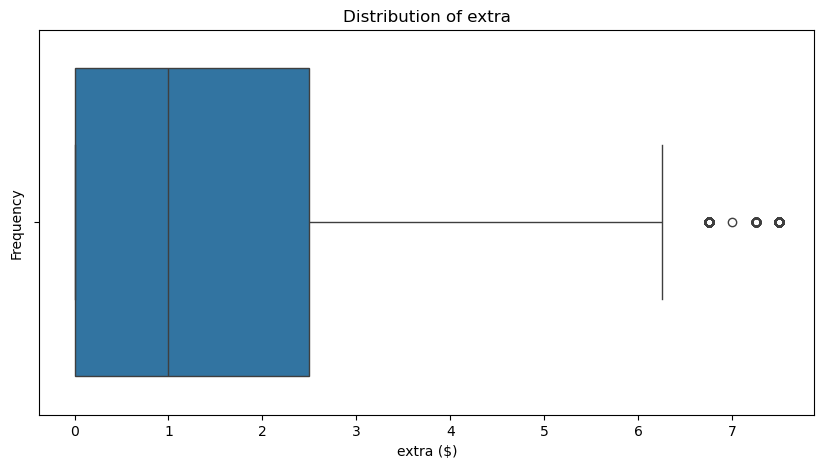

In [109]:
# extra outlier handling
new_df = handle_outliers(new_df, "extra", quantile=0.99, cap=True)

total_amount cap ::: 99.55
Box plot for total_amount before handling outliers


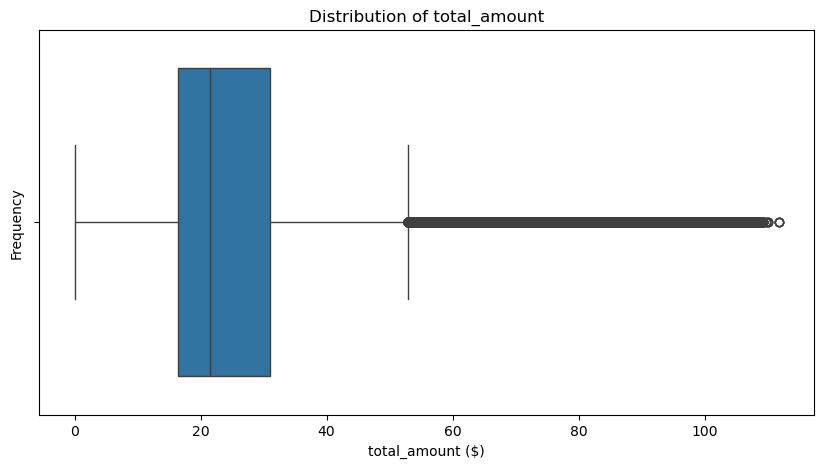

total_amount Describe()
count     283278.000000
mean          28.652819
std           20.655805
min            0.000000
25%           16.400000
50%           21.480000
75%           31.000000
max          111.800000
median        21.480000
Name: total_amount, dtype: float64 

Box plot for total_amount after handling outliers


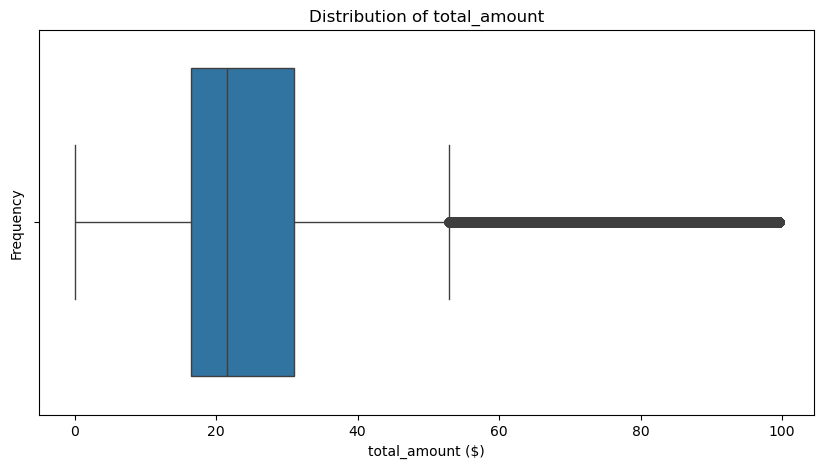

In [110]:
# Finally total_amount outlier handling
new_df["total_amount"] = new_df['fare_amount'] + new_df['tip_amount'] + new_df['tolls_amount'] + new_df['extra'] + new_df['mta_tax'] + new_df['congestion_surcharge'] + new_df['combined_airport_fee'] + new_df['improvement_surcharge']
new_df = handle_outliers(new_df, "total_amount", quantile=0.99, cap=True)

In [112]:
# Do any columns need standardising?

# payment_type
new_df['payment_type'] = new_df['payment_type'].replace({
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided trip"
})


# RatecodeID
new_df['RatecodeID'] = new_df['RatecodeID'].replace({
    1: "Standard rate",
    2: "JFK",
    3: "Newark",
    4: "Nassau or Westchester",
    5: "Negotiated Fare",
    6: "Group Ride"
})

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [115]:
new_df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'combined_airport_fee',
 'trip_duration',
 'pickup_hour',
 'pickup_day_of_week',
 'fare_per_mile']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: Numerical
* `tpep_dropoff_datetime`: Numerical
* `passenger_count`: Numerical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Categorical
* `DOLocationID`: Categorical
* `payment_type`: Categorical
* `pickup_hour`: Numerical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`: Numerical
* `extra`: Numerical
* `mta_tax`: Numerical
* `tip_amount`: Numerical
* `tolls_amount`: Numerical
* `improvement_surcharge`: Numerical
* `total_amount`: Numerical
* `congestion_surcharge`: Numerical
* `airport_fee`: Numerical

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

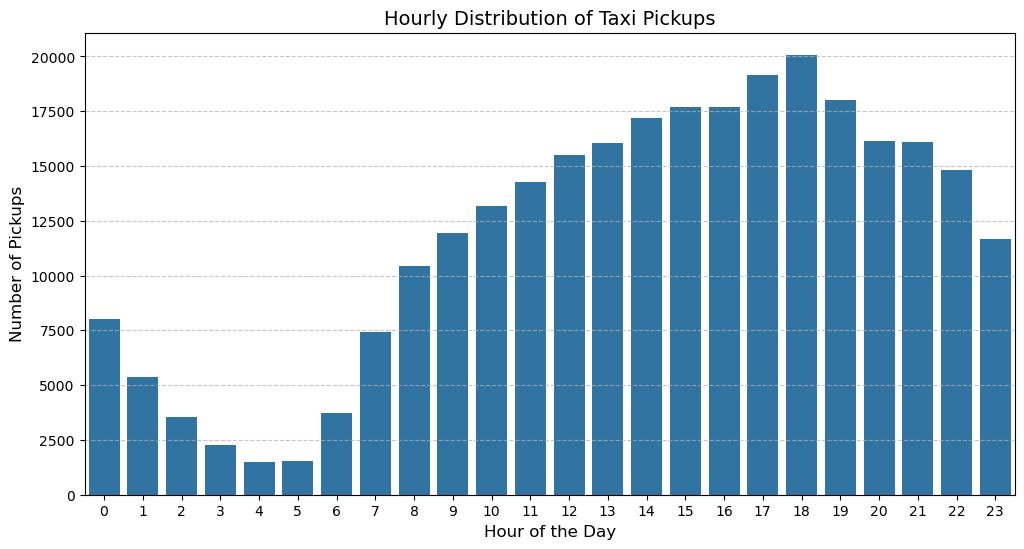

In [125]:
# Find and show the hourly trends in taxi pickups

def plot_hourly_pickups(df):
    """Plots the hourly distribution of taxi pickups."""
    
    hourly_df = df['pickup_hour'].value_counts().sort_index().reset_index()
    hourly_df.columns = ['pickup_hour', 'pickup_count']

    # Plot the data
    plt.figure(figsize=(12, 6))
    sns.barplot(data=hourly_df, x="pickup_hour", y="pickup_count")

    plt.title("Hourly Distribution of Taxi Pickups", fontsize=14)
    plt.xlabel("Hour of the Day", fontsize=12)
    plt.ylabel("Number of Pickups", fontsize=12)
    plt.xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_hourly_pickups(new_df)

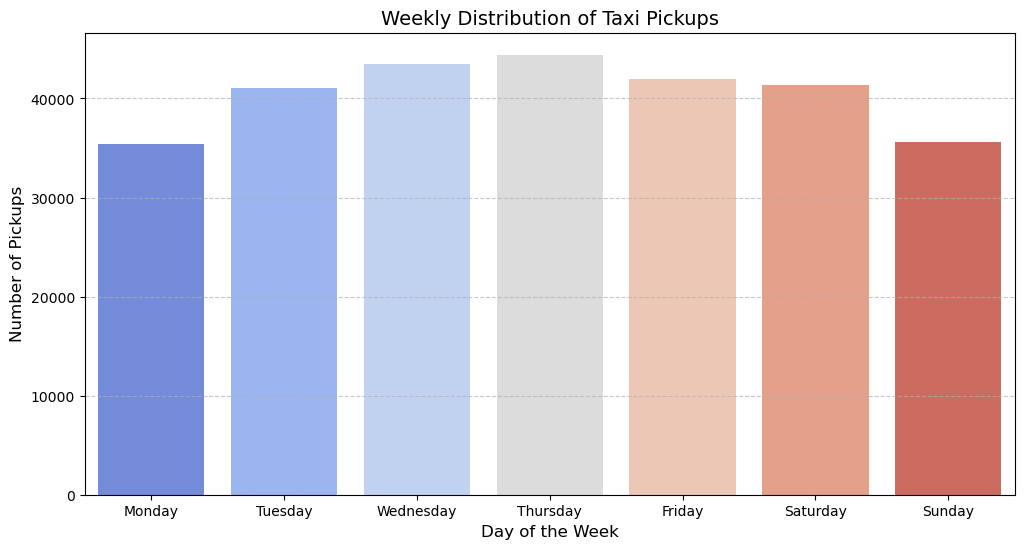

In [127]:
# Find and show the daily trends in taxi pickups (days of the week)

def plot_weekly_pickups(df):
    """Plots the weekly distribution of taxi pickups."""
    
    # Compute pickup count per day
    daywise_df = df['pickup_day_of_week'].value_counts().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ]).reset_index()
    
    daywise_df.columns = ['pickup_day_of_week', 'pickup_count']

    # Plot the data
    plt.figure(figsize=(12, 6))
    sns.barplot(data=daywise_df, x="pickup_day_of_week", y="pickup_count", palette="coolwarm")
    plt.title("Weekly Distribution of Taxi Pickups", fontsize=14)
    plt.xlabel("Day of the Week", fontsize=12)
    plt.ylabel("Number of Pickups", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

plot_weekly_pickups(new_df)

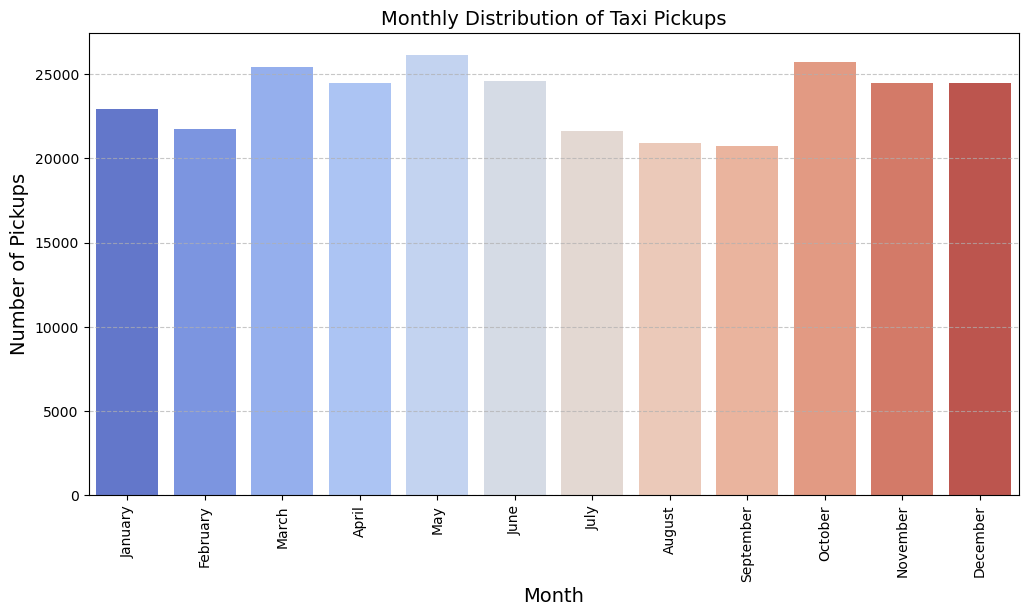

In [129]:
# Show the monthly trends in pickups
def plot_monthly_pickups(df):
    """Plots the monthly distribution of taxi pickups."""
    
    # Ensure datetime format and extract month name
    df['pickup_month_name'] = df['tpep_pickup_datetime'].dt.month_name()

    # Compute pickup count per month
    monthly_df = df['pickup_month_name'].value_counts().reindex([
        'January', 'February', 'March', 'April', 'May', 'June', 
        'July', 'August', 'September', 'October', 'November', 'December'
    ]).reset_index()
    
    monthly_df.columns = ['pickup_month_name', 'pickup_count']
    # Plot the data
    plt.figure(figsize=(12, 6))
    sns.barplot(data=monthly_df, x="pickup_month_name", y="pickup_count", palette="coolwarm")

    plt.title("Monthly Distribution of Taxi Pickups", fontsize=14)
    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Number of Pickups", fontsize=14)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

plot_monthly_pickups(new_df)

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [133]:
# Analyse the above parameters

columns_to_check = ['fare_amount', 'tip_amount', 'total_amount', 'trip_distance']

# Filter DataFrame to selected columns
df_selected = new_df[columns_to_check]

summary_df = pd.DataFrame({
    'data_type': df_selected.dtypes.astype(str),
    'null_value(%)': df_selected.isna().mean().mul(100).round(2),
    'negative_value(%)': df_selected.apply(lambda col: (col < 0).sum() / len(col) * 100 
                                           if np.issubdtype(col.dtype, np.number) else 0).round(2),
    'zero_value(%)': df_selected.apply(lambda col: (col == 0).sum() / len(col) * 100 
                                       if np.issubdtype(col.dtype, np.number) else 0).round(2)
})

summary_df = summary_df.reset_index().rename(columns={'index': 'column'})
print(summary_df)

          column data_type  null_value(%)  negative_value(%)  zero_value(%)
0    fare_amount   float64            0.0                0.0           1.10
1     tip_amount   float64            0.0                0.0          21.88
2   total_amount   float64            0.0                0.0           0.02
3  trip_distance   float64            0.0                0.0           1.08


Observations
1. No Negative Values Found

    All financial parameters (fare_amount, tip_amount, total_amount) and trip_distance have 0% negative values, ensuring no incorrect     negative entries.

2. Zero Values Exist in Some Columns

    tip_amount (21.88% zeros) → This is expected since tipping is optional, and many passengers do not leave a tip.
    
    trip_distance (1.08% zeros) → Possible reasons:
    
            Short trips within the same zone (e.g., airport/mall shuttle).
            
            GPS errors or incorrect data entry.
            
            Canceled rides where timestamps were still recorded.
    
    fare_amount (1.10% zeros) & total_amount (0.02% zeros) → These rare cases may indicate:
    
            System errors.
            
            Free/promotional rides.

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

Yes! Creating a filtered copy of the DataFrame, excluding rows with zero values, can be useful for cleaner analysis. However, whether to remove them completely depends on the context.

Valid zero values: A tip amount and fare_amount and total_amount of 0 may be valid, while trip_distance of 0 might be valid if the trip occurred within the same zone (e.g: a short shuttle ride).

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

Zero distance trips occur when pickup and drop-off locations are in the same zone. Whether to drop these cases depends on the analysis goal. 
If they represent valid short trips (e.g., within an airport or mall) and have a fare or duration, they should be retained. If they result from data errors, they can be removed. A balanced approach is to filter out zero-distance trips only if they also have zero fare or duration to avoid losing valid data.

In [140]:
# Create a df with non zero entries for the selected parameters.

new_df = new_df[~((new_df['trip_distance'] == 0) & (new_df['fare_amount'] == 0) & (new_df['trip_duration'] == 0))]

Retain zero-distance trips only if they have either a fare or duration, indicating valid short trips.

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend


Monthly Revenue Summary:
    pickup_month_name  total_revenue  avg_revenue
0            January      621732.10        27.12
1           February      590037.40        27.12
2              March      713325.73        28.08
3              April      697160.42        28.49
4                May      762334.60        29.17
5               June      715562.31        29.14
6               July      627502.97        29.02
7             August      595489.64        28.52
8          September      613860.74        29.60
9            October      758968.47        29.51
10          November      707989.99        28.91
11          December      703642.29        28.72 



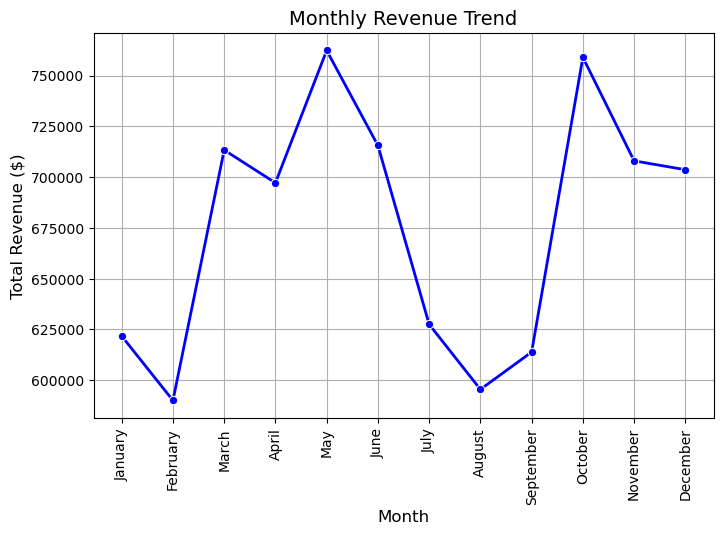

In [144]:
# Group data by month and analyse monthly revenue

def analyze_monthly_revenue(df):
    """Analyzes monthly revenue trends with total and average revenue per trip."""

    # Extract month and month name
    df = df.assign(
        pickup_month=df['tpep_pickup_datetime'].dt.month,
        pickup_month_name=df['tpep_pickup_datetime'].dt.strftime('%B')
    )

    # Compute revenue metrics
    monthly_revenue = (
        df.groupby(['pickup_month', 'pickup_month_name'])['total_amount']
        .agg(total_revenue='sum', avg_revenue='mean')
        .reset_index()
        .sort_values("pickup_month")
    )

    # Display summary
    print("\nMonthly Revenue Summary:\n", monthly_revenue[['pickup_month_name', 'total_revenue', 'avg_revenue']].round(2),"\n")

    # Plot revenue trend
    plt.figure(figsize=(8, 5))
    sns.lineplot(
        data=monthly_revenue,
        x="pickup_month_name",
        y="total_revenue",
        marker="o",
        linewidth=2,
        color="blue"
    )

    plt.title("Monthly Revenue Trend", fontsize=14)
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Total Revenue ($)", fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(True)

    plt.show()

# Call function with filtered DataFrame
analyze_monthly_revenue(new_df)

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue


Proportion of Each Quarter in Revenue:
   pickup_quarter  total_revenue  revenue_proportion(%)
0               1     1925095.24                  23.74
1               2     2175057.33                  26.83
2               3     1836853.34                  22.66
3               4     2170600.75                  26.77 



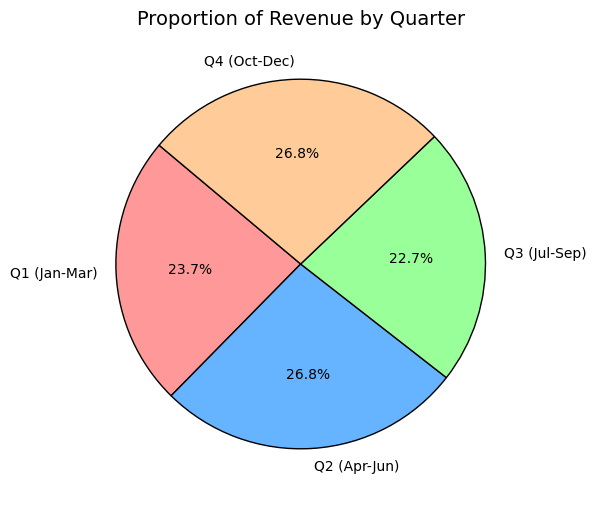

In [146]:
# Calculate proportion of each quarter

def analyze_quarterly_revenue(df):
    """Extracts quarter-wise revenue distribution and visualizes it."""
        
    # Compute quarterly revenue
    quarterly_revenue = (
        df.assign(pickup_quarter=df['tpep_pickup_datetime'].dt.quarter)
        .groupby('pickup_quarter')['total_amount']
        .sum()
        .reset_index(name='total_revenue')
    )

    # Compute revenue proportion
    quarterly_revenue['revenue_proportion(%)'] = (
        quarterly_revenue['total_revenue'] / quarterly_revenue['total_revenue'].sum() * 100
    )

    # Print summary
    print("\nProportion of Each Quarter in Revenue:")
    print(quarterly_revenue.round(2), "\n")

    # Define labels and values for the pie chart
    labels = ["Q1 (Jan-Mar)", "Q2 (Apr-Jun)", "Q3 (Jul-Sep)", "Q4 (Oct-Dec)"]
    sizes = quarterly_revenue['revenue_proportion(%)']
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
            startangle=140, wedgeprops={'edgecolor': 'black'})

    plt.title("Proportion of Revenue by Quarter", fontsize=14)
    plt.show()

# Call the function with your DataFrame
analyze_quarterly_revenue(new_df)

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

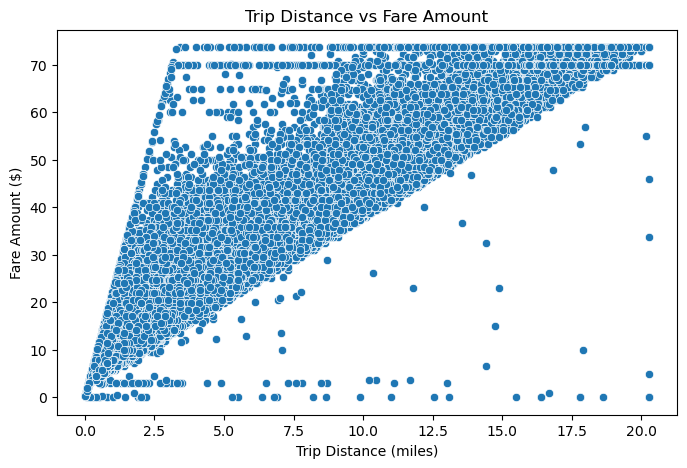

Correlation between Trip Distance and Fare Amount: 0.97


In [150]:
# Show how trip fare is affected by distance

new_df = new_df[new_df['trip_distance'] > 0]

# Scatter Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=new_df['trip_distance'], y=new_df['fare_amount'])
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.title("Trip Distance vs Fare Amount")
plt.show()

# Compute Correlation
correlation = new_df['trip_distance'].corr(new_df['fare_amount'])
print(f"Correlation between Trip Distance and Fare Amount: {correlation:.2f}")

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [153]:
# Show relationship between fare and trip duration

plt.figure(figsize=(8, 5))
sns.regplot(x=new_df["trip_duration"], y=new_df["fare_amount"], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

# Labels and Title
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Fare Amount ($)")
plt.title("Relationship Between Trip Duration and Fare Amount")
plt.show()

# Correlation
correlation = new_df["trip_duration"].corr(new_df["fare_amount"])
print()
print(f"Correlation between trip duration and fare amount: {correlation:.2f}")


Correlation between trip duration and fare amount: 0.28


In [154]:
# Show relationship between fare and number of passengers

# Box plot to show fare distribution for each passenger count
plt.figure(figsize=(8, 5))
sns.boxplot(x=new_df["passenger_count"], y=new_df["fare_amount"])

# Labels and title
plt.xlabel("Number of Passengers")
plt.ylabel("Fare Amount ($)")
plt.title("Relationship Between Number of Passengers and Fare Amount")

plt.show()

# Compute average fare per passenger count
avg_fare_per_passenger = new_df.groupby("passenger_count")["fare_amount"].mean()
print(avg_fare_per_passenger)

# Correlation
correlation = new_df["passenger_count"].corr(new_df["fare_amount"])
print()
print(f"Correlation between passenger count and fare amount: {correlation:.2f}")

passenger_count
1.0    18.552550
2.0    21.598760
3.0    21.094050
4.0    22.388327
5.0    18.309914
6.0    18.628542
Name: fare_amount, dtype: float64

Correlation between passenger count and fare amount: 0.05


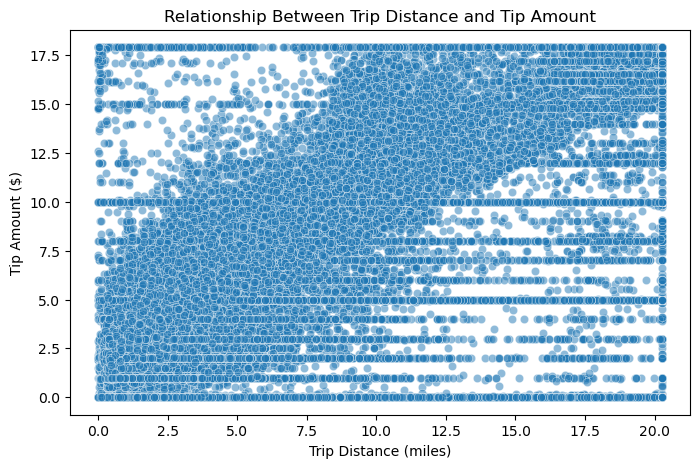

Correlation between trip distance and tip amount: 0.62


In [155]:
# Show relationship between tip and trip distance

# Scatter plot to show relationship between trip distance and tip amount
plt.figure(figsize=(8, 5))
sns.scatterplot(x=new_df["trip_distance"], y=new_df["tip_amount"], alpha=0.5)

# Labels and title
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Tip Amount ($)")
plt.title("Relationship Between Trip Distance and Tip Amount")

plt.show()

# Compute correlation
correlation = new_df["trip_distance"].corr(new_df["tip_amount"])
print(f"Correlation between trip distance and tip amount: {correlation:.2f}")

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

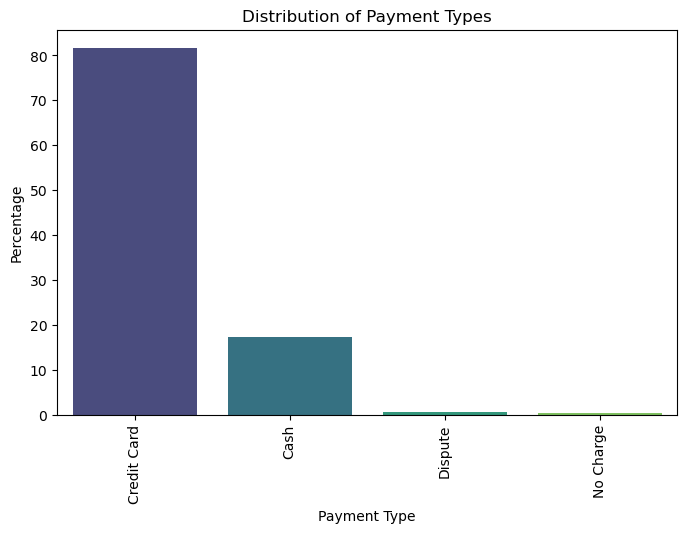

In [157]:
# Analyse the distribution of different payment types (payment_type).

# Count occurrences
payment_counts = new_df['payment_type'].value_counts(normalize=True) * 100

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=payment_counts.index, y=payment_counts.values, palette="viridis")

# Labels
plt.xlabel("Payment Type")
plt.ylabel("Percentage")
plt.title("Distribution of Payment Types")
plt.xticks(rotation=90)
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [162]:
!pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [164]:
import geopandas as gpd

# Read the shapefile using geopandas
shape_file_path = os.path.join("taxi_zones/", 'taxi_zones.shp')
zones = gpd.read_file(shape_file_path)
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

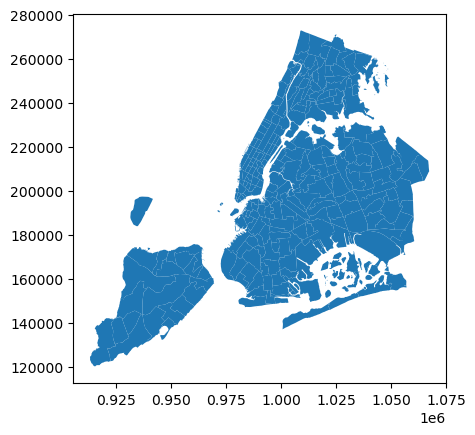

In [166]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [169]:
# Merge zones and trip records using locationID and PULocationID
merged_df = new_df.merge(zones, left_on="PULocationID", right_on="LocationID", how="left")
merged_df.head(3)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:38:41   2023-01-01 00:41:42              1.0   
1         2  2023-01-01 00:43:59   2023-01-01 01:13:02              2.0   
2         2  2023-01-01 00:37:44   2023-01-01 00:46:31              1.0   

   trip_distance     RatecodeID  PULocationID  DOLocationID payment_type  \
0           0.43  Standard rate           114           144  Credit Card   
1           1.78  Standard rate           100           143  Credit Card   
2           1.19  Standard rate           107           234  Credit Card   

   fare_amount  ...  pickup_day_of_week  fare_per_mile  pickup_month_name  \
0          5.1  ...              Sunday      11.860465            January   
1         23.3  ...              Sunday      13.089888            January   
2         10.0  ...              Sunday       8.403361            January   

   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0     114.0    0.031727    0.000047  Greenwich Village South       114.0   
1     100.0    0.024813    0.000037         Garment District       100.0   
2     107.0    0.038041    0.000075                 Gramercy       107.0   

     borough                                           geometry  
0  Manhattan  POLYGON ((986306.712 203122.786, 986300.242 20...  
1  Manhattan  POLYGON ((987770.527 212686.678, 987638.873 21...  
2  Manhattan  POLYGON ((989131.643 205749.904, 989084.531 20...  

[3 rows x 30 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [171]:
# Group data by location and calculate the number of trips
trip_counts = merged_df.groupby("PULocationID").size().reset_index(name="total_trips")
trip_counts = trip_counts.sort_values(by="total_trips", ascending=False)
print(trip_counts.head(10))

     PULocationID  total_trips
89            132        14739
171           237        13422
111           161        13103
170           236        12034
94            138        10044
112           162         9997
131           186         9936
165           230         9494
97            142         9425
120           170         8540


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [173]:
# Merge trip counts back to the zones GeoDataFrame
zones_with_trips = zones.merge(trip_counts, left_on="LocationID", right_on="PULocationID", how="left")
zones_with_trips.drop(columns=['PULocationID'], inplace=True)  # Remove extra column
zones_with_trips.head(10)

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   
5         6    0.150491    0.000606  Arrochar/Fort Wadsworth           6   
6         7    0.107417    0.000390                  Astoria           7   
7         8    0.027591    0.000027             Astoria Park           8   
8         9    0.099784    0.000338               Auburndale           9   
9        10    0.099839    0.000436             Baisley Park          10   

         borough                                           geometry  \
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...   
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...   
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...   
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...   
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...   
5  Staten Island  POLYGON ((966568.747 158679.855, 966615.256 15...   
6         Queens  POLYGON ((1010804.218 218919.641, 1011049.165 ...   
7         Queens  POLYGON ((1005482.276 221686.466, 1005304.898 ...   
8         Queens  POLYGON ((1043803.993 216615.925, 1043849.708 ...   
9         Queens  POLYGON ((1044355.072 190734.321, 1044612.122 ...   

   total_trips  
0         14.0  
1          NaN  
2          NaN  
3        284.0  
4          NaN  
5          2.0  
6        100.0  
7          NaN  
8          1.0  
9         63.0

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

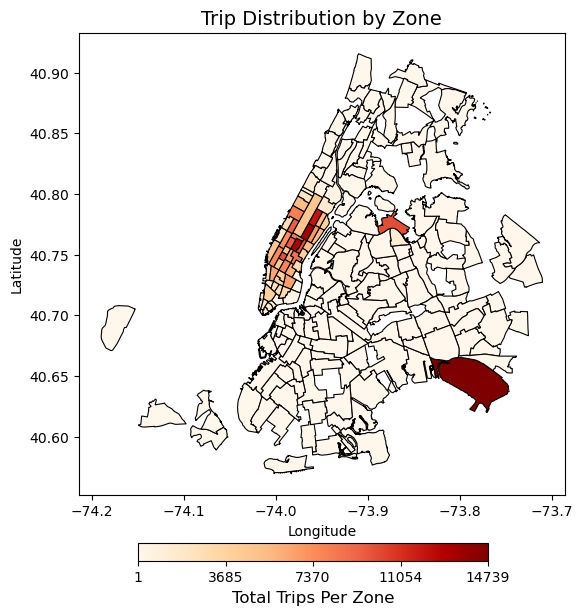

In [177]:
# Define figure and axis
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

zones_with_trips = zones_with_trips.to_crs(epsg=4326)

# Colormap
cmap = cm.OrRd
vmin, vmax = zones_with_trips["total_trips"].min(), zones_with_trips["total_trips"].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Plot the map and display it
zones_with_trips.plot(column="total_trips", cmap=cmap, linewidth=0.8, edgecolor="black", ax=ax)

# Color bar
cbar_ax = fig.add_axes([0.25, 0.00, 0.5, 0.03])  # Adjust (left, bottom, width, height)
cb = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, cax=cbar_ax, orientation="horizontal")

# Colorbar tick positions and labels
tick_values = np.linspace(vmin, vmax, num=5)  # Define 5 tick positions
cbar.set_ticks(tick_values)  
cbar.set_ticklabels([f"{int(val)}" for val in tick_values])  # Convert to integers

# Custom legend title
cbar.set_label("Total Trips Per Zone", fontsize=12)

# Labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Trip Distribution by Zone", fontsize=14)

plt.show()

In [178]:
# can you try displaying the zones DF sorted by the number of trips?
# Sort no of trips in descending order
zones_with_trips = zones_with_trips.sort_values(by="total_trips", ascending=False)
zones_with_trips.head(10)

OBJECTID  Shape_Leng  Shape_Area                          zone  \
131       132    0.245479    0.002038                   JFK Airport   
236       237    0.042213    0.000096         Upper East Side South   
160       161    0.035804    0.000072                Midtown Center   
235       236    0.044252    0.000103         Upper East Side North   
137       138    0.107467    0.000537             LaGuardia Airport   
161       162    0.035270    0.000048                  Midtown East   
185       186    0.024696    0.000037  Penn Station/Madison Sq West   
229       230    0.031028    0.000056     Times Sq/Theatre District   
141       142    0.038176    0.000076           Lincoln Square East   
169       170    0.045769    0.000074                   Murray Hill   

     LocationID    borough                                           geometry  \
131         132     Queens  MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ...   
236         237  Manhattan  POLYGON ((-73.96613 40.76218, -73.96658 40.761...   
160         161  Manhattan  POLYGON ((-73.97534 40.7553, -73.97581 40.7546...   
235         236  Manhattan  POLYGON ((-73.95779 40.7736, -73.95826 40.7729...   
137         138     Queens  MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ...   
161         162  Manhattan  POLYGON ((-73.97122 40.75519, -73.97168 40.754...   
185         186  Manhattan  POLYGON ((-73.99097 40.74542, -73.99142 40.744...   
229         230  Manhattan  POLYGON ((-73.98362 40.75552, -73.98412 40.754...   
141         142  Manhattan  POLYGON ((-73.98148 40.76773, -73.98155 40.767...   
169         170  Manhattan  POLYGON ((-73.97203 40.7458, -73.97213 40.7456...   

     total_trips  
131      14739.0  
236      13422.0  
160      13103.0  
235      12034.0  
137      10044.0  
161       9997.0  
185       9936.0  
229       9494.0  
141       9425.0  
169       8540.0

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [187]:
# Find routes which have the slowest speeds at different times of the day

# Ensure trip_duration is in hours for speed calculation
new_df['trip_duration_hours'] = new_df['trip_duration'] / 60  # Convert minutes to hours

# Merge trip data with zones data to get pickup zone names
filtered_df = new_df.merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')
filtered_df.rename(columns={'zone': 'PickupZone'}, inplace=True)
filtered_df['PickupZone'].fillna('Unknown', inplace=True)
filtered_df.drop(columns=['LocationID'], inplace=True)  # Remove extra column

# # Merge again to get drop-off zone names
filtered_df = filtered_df.merge(zones[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID', how='left')
filtered_df.rename(columns={'zone': 'DropoffZone'}, inplace=True)
filtered_df['DropoffZone'].fillna('Unknown', inplace=True)
filtered_df.drop(columns=['LocationID'], inplace=True)  # Remove extra column

# # Group by route and hour
route_speed = filtered_df.groupby(['PULocationID', 'DOLocationID', 'pickup_hour', 'PickupZone', 'DropoffZone']).agg(
    avg_distance=('trip_distance', 'mean'),
    avg_duration=('trip_duration_hours', 'mean')
).reset_index()

# Calculate speed (distance per hour)
route_speed['speed'] = route_speed['avg_distance'] / route_speed['avg_duration']

# Identify slowest routes by hour (lowest speed)
slowest_routes = route_speed.nsmallest(10, 'speed')  # Get 10 slowest routes

# Display results
slowest_routes[['PickupZone', 'DropoffZone', 'pickup_hour', 'speed']]

PickupZone                       DropoffZone  \
1192                       Bloomingdale                      Bloomingdale   
42999           Queensbridge/Ravenswood           Queensbridge/Ravenswood   
31778                   Lower East Side                   Lower East Side   
8333                  East Harlem North                      Central Park   
8378                  East Harlem North                 East Harlem South   
3209                          Chinatown                 Battery Park City   
3275                          Chinatown          Financial District North   
2242               Central Harlem North                    Manhattanville   
46551         Times Sq/Theatre District                          Kips Bay   
43088  Saint Michaels Cemetery/Woodside  Saint Michaels Cemetery/Woodside   

       pickup_hour     speed  
1192             9  0.000837  
42999           12  0.030431  
31778           22  0.053151  
8333            17  0.053818  
8378            20  0.063123  
3209            20  0.077371  
3275            23  0.081240  
2242            18  0.085076  
46551            3  0.085294  
43088            5  0.092545

How does identifying high-traffic, high-demand routes help us?

Identifying high-traffic, high-demand routes helps in several ways, especially for businesses, city planners, and ride-hailing companies. 

1. Optimizing Fleet Management 

Helps allocate more drivers to busy areas during peak hours.

Reduces passenger wait times by ensuring cabs are available where demand is high.

2. Dynamic Pricing & Revenue Maximization 

High-demand routes can have higher fare pricing (surge pricing) to increase revenue.

Companies can offer discounts or promotions in less busy areas to balance demand.

3. Traffic Congestion Management

Helps city planners optimize road infrastructure by identifying bottlenecks.

Authorities can adjust traffic signals or create dedicated taxi lanes in high-traffic zones.

4. Enhancing Customer Experience

Reduces trip cancellations due to driver unavailability in busy areas.

Allows pre-booking options for frequently used routes.

5. Strategic Expansion 

Ride-hailing companies can expand services to underserved but high-demand areas.

Taxi companies can adjust operations (e.g., adding more cabs at airports, train stations).

6. Fuel and Cost Efficiency

Helps optimize routes to reduce fuel costs and improve driver earnings.

Identifies shorter, less congested paths for faster pickups and drop-offs.

7. Better Marketing & Partnerships

High-demand locations (e.g., malls, stadiums) are great places for advertisements.

Ride-hailing apps can partner with businesses in these areas (e.g., discounts for mall rides).


**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

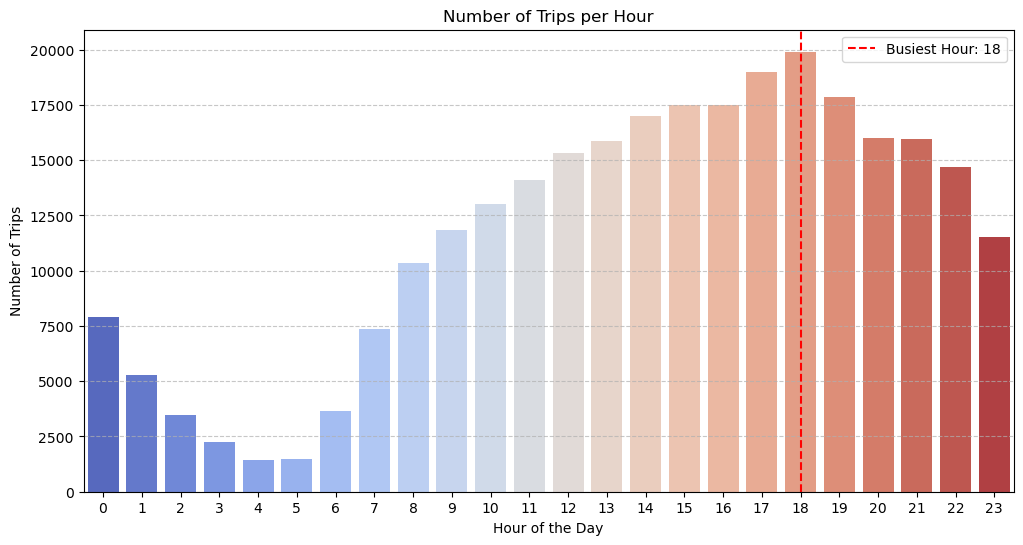

Busiest hour: 18 with 19908 trips.


In [191]:
# Visualise the number of trips per hour and find the busiest hour

# Count trips per hour
trips_per_hour = filtered_df.groupby('pickup_hour').size().reset_index(name='sampled_num_trips')

# Find the busiest hour
busiest_hour = trips_per_hour.loc[trips_per_hour['sampled_num_trips'].idxmax()]

# Plot trips per hour
plt.figure(figsize=(12, 6))
sns.barplot(x=trips_per_hour['pickup_hour'], y=trips_per_hour['sampled_num_trips'], palette='coolwarm')

# Highlight the busiest hour
plt.axvline(busiest_hour['pickup_hour'], color='red', linestyle='--', label=f"Busiest Hour: {busiest_hour['pickup_hour']}")

# Labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Hour')
plt.xticks(range(24))  # Ensure all hours are visible
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

# Print busiest hour
print(f"Busiest hour: {busiest_hour['pickup_hour']} with {busiest_hour['sampled_num_trips']} trips.")

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [208]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.05

trips_per_hour['actual_num_trips'] = trips_per_hour['sampled_num_trips'] / sample_fraction
top_5_busiest = trips_per_hour.nlargest(5, 'actual_num_trips')
print(top_5_busiest[['pickup_hour', 'sampled_num_trips', 'actual_num_trips']])

    pickup_hour  sampled_num_trips  actual_num_trips
18           18              19908          398160.0
17           17              18978          379560.0
19           19              17872          357440.0
15           15              17512          350240.0
16           16              17480          349600.0


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

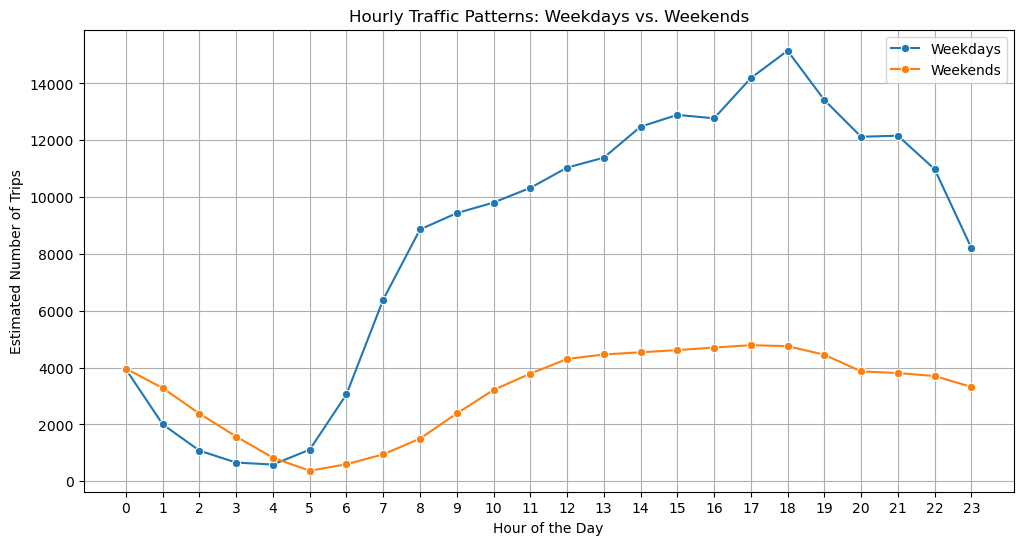

In [211]:
# Compare traffic trends for the week days and weekends

weekdays = {'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'}
weekends = {'Saturday', 'Sunday'}

# Separate weekdays and weekends
weekdays_df = filtered_df[filtered_df['pickup_day_of_week'].isin(weekdays)]
weekends_df = filtered_df[filtered_df['pickup_day_of_week'].isin(weekends)]

weekday_trips = weekdays_df.groupby('pickup_hour').size().reset_index(name='weekday_trips')
weekend_trips = weekends_df.groupby('pickup_hour').size().reset_index(name='weekend_trips')

hourly_comparison = weekday_trips.merge(weekend_trips, on='pickup_hour', how='outer').fillna(0)

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_comparison['pickup_hour'], y=hourly_comparison['weekday_trips'], label='Weekdays', marker='o')
sns.lineplot(x=hourly_comparison['pickup_hour'], y=hourly_comparison['weekend_trips'], label='Weekends', marker='o')

plt.xlabel("Hour of the Day")
plt.ylabel("Estimated Number of Trips")
plt.title("Hourly Traffic Patterns: Weekdays vs. Weekends")
plt.legend()
plt.xticks(range(24))  
plt.grid(True)
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

From the graph, we can infer the following traffic patterns for weekdays and weekends:

Weekday Patterns:

There is a sharp increase in traffic between 6 AM and 9 AM, peaking at around 8-9 AM, which likely corresponds to the morning rush hour.

Traffic remains high throughout the day, reaching another peak in the evening between 5 PM and 7 PM, likely due to the evening rush hour.

After 7 PM, the number of trips starts declining, with a significant drop after 10 PM.

Weekend Patterns:

Traffic is more evenly distributed throughout the day, with no sharp spikes.

The number of trips starts increasing after 7 AM, peaking around 12 PM to 6 PM.

The evening decline is more gradual compared to weekdays.


How Will Finding Busy and Quiet Hours Help?

Traffic Management: Understanding peak hours helps city planners optimize traffic signals, road closures, and public transport availability to reduce congestion.

Business Planning: Businesses can adjust their operating hours, staffing, and promotional activities based on peak traffic periods.

Ride-Sharing & Public Transport: Taxi and ride-sharing services can adjust surge pricing and availability, while public transport can schedule more buses/trains during peak hours.

Energy & Infrastructure Planning: Power consumption and infrastructure usage can be optimized by predicting high-demand times.

Safety Measures: Law enforcement and emergency response teams can allocate resources more effectively during peak hours.

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

Top 10 pickup zones ::::  ['JFK Airport', 'LaGuardia Airport', 'Lincoln Square East', 'Midtown Center', 'Midtown East', 'Murray Hill', 'Penn Station/Madison Sq West', 'Times Sq/Theatre District', 'Upper East Side North', 'Upper East Side South'] 

Top 10 dropoff zones ::::  ['East Chelsea', 'Lenox Hill West', 'Lincoln Square East', 'Midtown Center', 'Midtown East', 'Murray Hill', 'Times Sq/Theatre District', 'Upper East Side North', 'Upper East Side South', 'Upper West Side South'] 



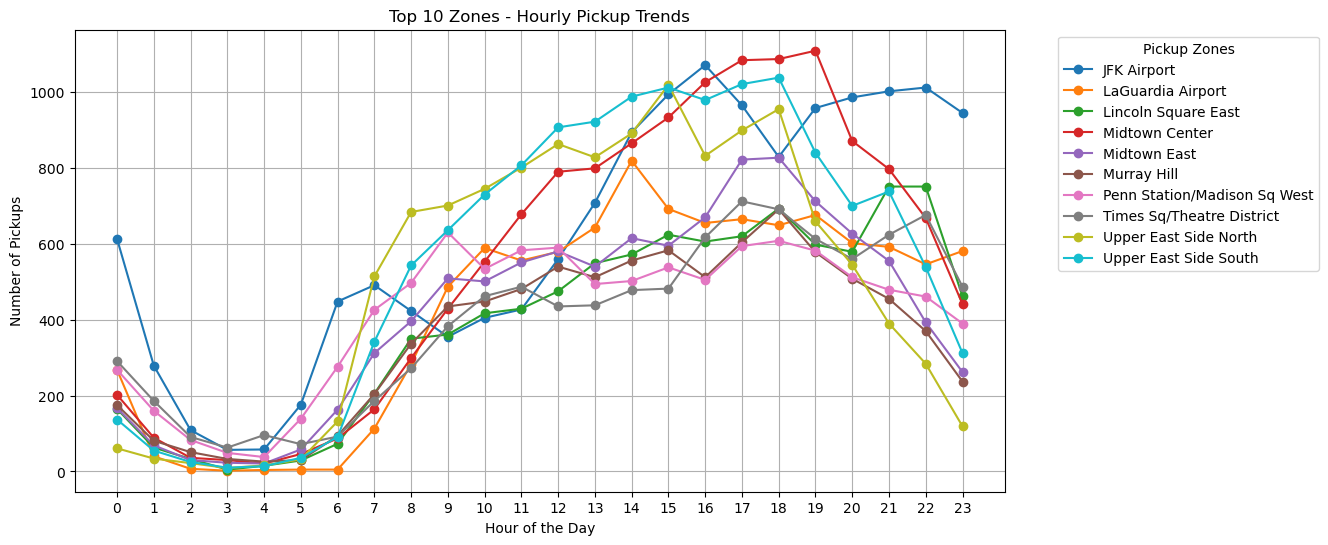

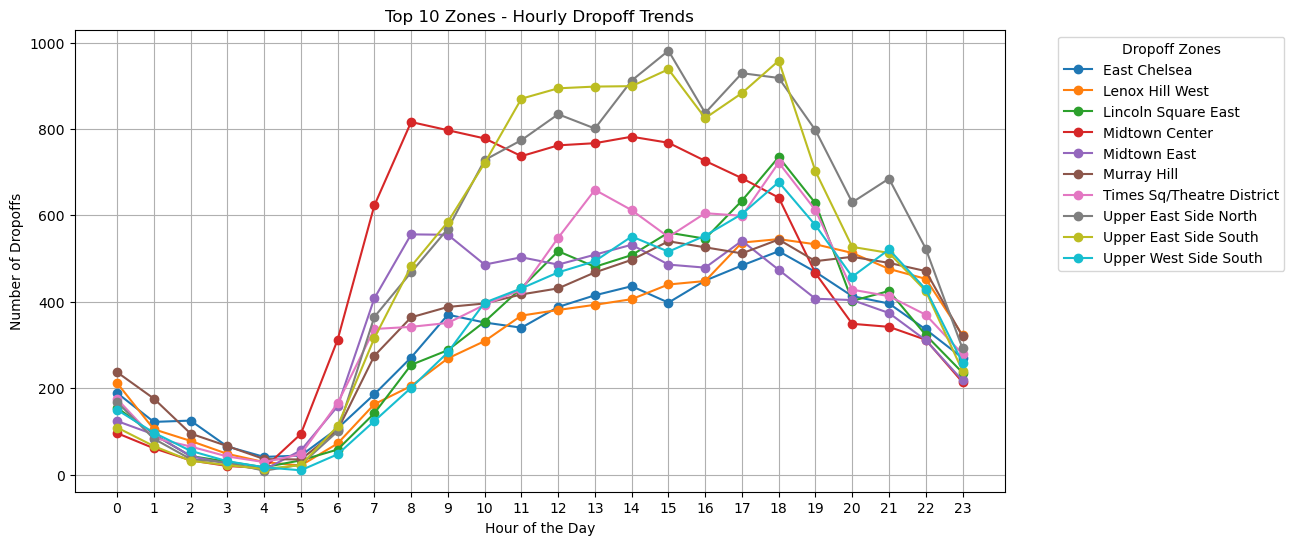

In [217]:
# Find top 10 pickup and dropoff zones

top_pickup_zones = filtered_df['PULocationID'].value_counts().head(10).index
top_pickups_df = filtered_df[filtered_df['PULocationID'].isin(top_pickup_zones)]

top_dropoff_zones = filtered_df['DOLocationID'].value_counts().head(10).index
top_dropoffs_df = filtered_df[filtered_df['DOLocationID'].isin(top_dropoff_zones)]

pickup_trends = top_pickups_df.groupby(['pickup_hour', 'PULocationID']).size().unstack(fill_value=0)
dropoff_trends = top_dropoffs_df.groupby(['pickup_hour', 'DOLocationID']).size().unstack(fill_value=0)

pickup_trends = pickup_trends.rename(columns=zones.set_index('LocationID')['zone'])
dropoff_trends = dropoff_trends.rename(columns=zones.set_index('LocationID')['zone'])

print(f"Top 10 pickup zones :::: ", pickup_trends.columns.tolist(),"\n")
print(f"Top 10 dropoff zones :::: ", dropoff_trends.columns.tolist(),"\n")

# Plot pickup trends
pickup_trends.plot(kind='line', marker='o', colormap='tab10', figsize=(12, 6))
plt.title("Top 10 Zones - Hourly Pickup Trends")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Pickups")
plt.xticks(range(24))
plt.legend(title="Pickup Zones", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Plot dropoff trends
dropoff_trends.plot(kind='line', marker='o', colormap='tab10', figsize=(12, 6))
plt.title("Top 10 Zones - Hourly Dropoff Trends")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Dropoffs")
plt.xticks(range(24))
plt.legend(title="Dropoff Zones", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [220]:
# Find the top 10 and bottom 10 pickup/dropoff ratios

# Count pickups and dropoffs per zone
pickup_counts = filtered_df['PULocationID'].value_counts().rename('pickup_count').sort_index()
dropoff_counts = filtered_df['DOLocationID'].value_counts().rename('dropoff_count').sort_index()

zone_ratios = pd.DataFrame({'pickup_count': pickup_counts, 'dropoff_count': dropoff_counts})

zone_ratios['pickup_drop_ratio'] = zone_ratios['pickup_count'] / zone_ratios['dropoff_count']

# Handle divide-by-zero (replace Inf with NaN and then with 0)
zone_ratios.replace([np.inf, -np.inf], np.nan, inplace=True)
zone_ratios.fillna(0, inplace=True)

zone_ratios = zone_ratios.merge(zones[['LocationID', 'zone']], left_index=True, right_on='LocationID', how='left')

# # Get top 10 highest and lowest ratios
top_10_highest = zone_ratios.nlargest(10, 'pickup_drop_ratio')[['zone', 'pickup_drop_ratio']]
top_10_lowest = zone_ratios.nsmallest(10, 'pickup_drop_ratio')[['zone', 'pickup_drop_ratio']]

# Display results
print("Top 10 Zones with Highest Pickup/Dropoff Ratio:")
print(top_10_highest)

print("\nTop 10 Zones with Lowest Pickup/Dropoff Ratio:")
print(top_10_lowest)

Top 10 Zones with Highest Pickup/Dropoff Ratio:
                                   zone  pickup_drop_ratio
69.0                      East Elmhurst           8.295302
131.0                       JFK Airport           4.910210
137.0                 LaGuardia Airport           2.868796
206.0  Saint Michaels Cemetery/Woodside           2.000000
185.0      Penn Station/Madison Sq West           1.601354
113.0           Greenwich Village South           1.402957
248.0                      West Village           1.375725
42.0                       Central Park           1.356671
161.0                      Midtown East           1.213497
99.0                   Garment District           1.211856

Top 10 Zones with Lowest Pickup/Dropoff Ratio:
                                     zone  pickup_drop_ratio
2.0               Allerton/Pelham Gardens                0.0
7.0                          Astoria Park                0.0
10.0                           Bath Beach                0.0
14.0       

**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [223]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones

night_hours = filtered_df[filtered_df['pickup_hour'].isin([23, 0, 1, 2, 3, 4, 5])]

top_night_pickups = (
    night_hours['PULocationID']
    .value_counts()
    .head(10)
    .rename_axis('PULocationID')  # Ensure the index has a name
    .reset_index(name='Pickup_Count')  # Convert index to column
    .merge(zones[['LocationID', 'zone']], left_on='PULocationID', right_on='LocationID', how='left')
    .drop(columns=['LocationID'])
    .rename(columns={'zone': 'PickupZone'})
)

top_night_dropoffs = (
    night_hours['DOLocationID']
    .value_counts()
    .head(10)
    .rename_axis('DOLocationID')  # Ensure the index has a name
    .reset_index(name='Dropoff_Count')  # Convert index to column
    .merge(zones[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID', how='left')
    .drop(columns=['LocationID'])
    .rename(columns={'zone': 'DropoffZone'})
)

print("Top 10 Pickup Zones at Night (11PM-5AM):\n", top_night_pickups)
print("\nTop 10 Dropoff Zones at Night (11PM-5AM):\n", top_night_dropoffs)

Top 10 Pickup Zones at Night (11PM-5AM):
    PULocationID  Pickup_Count                    PickupZone
0            79          2431                  East Village
1           132          2237                   JFK Airport
2           249          1984                  West Village
3            48          1547                  Clinton East
4           148          1513               Lower East Side
5           114          1375       Greenwich Village South
6           230          1286     Times Sq/Theatre District
7           186          1127  Penn Station/Madison Sq West
8           164           960                 Midtown South
9            68           928                  East Chelsea

Top 10 Dropoff Zones at Night (11PM-5AM):
    DOLocationID  Dropoff_Count                    DropoffZone
0            79           1232                   East Village
1            48           1101                   Clinton East
2           170            965                    Murray Hill
3     

Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [226]:
# Filter for night hours (11 PM to 5 AM)

night_hours = filtered_df[filtered_df['pickup_hour'].isin([23, 0, 1, 2, 3, 4, 5])]
day_hours = filtered_df[filtered_df['pickup_hour'].isin(range(6, 23))]

night_revenue = night_hours['total_amount'].sum()
day_revenue = day_hours['total_amount'].sum()
total_revenue = night_revenue + day_revenue

night_revenue_share = (night_revenue / total_revenue) * 100
day_revenue_share = (day_revenue / total_revenue) * 100

print(f"Nighttime Revenue Share (11PM-5AM): {night_revenue_share:.2f}%")
print(f"Daytime Revenue Share (6AM-10PM): {day_revenue_share:.2f}%")

Nighttime Revenue Share (11PM-5AM): 12.02%
Daytime Revenue Share (6AM-10PM): 87.98%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [230]:
# Analyse the fare per mile per passenger for different passenger counts

fare_per_mile = (
    filtered_df.groupby('passenger_count')
    .apply(lambda x: (x['fare_amount'].sum() / x['trip_distance'].sum()))
    .reset_index(name='avg_fare_per_mile')
)

fare_per_mile['fare_per_mile_per_passenger'] = fare_per_mile['avg_fare_per_mile'] / fare_per_mile['passenger_count']

print(fare_per_mile)

   passenger_count  avg_fare_per_mile  fare_per_mile_per_passenger
0              1.0           5.674059                     5.674059
1              2.0           5.304846                     2.652423
2              3.0           5.426593                     1.808864
3              4.0           5.360428                     1.340107
4              5.0           5.690056                     1.138011
5              6.0           5.738986                     0.956498


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [233]:
# Compare the average fare per mile for different days and for different times of the day

filtered_df['fare_per_mile'] = filtered_df['fare_amount'] / filtered_df['trip_distance']

hourly_fare_per_mile = (
    filtered_df.groupby('pickup_hour')['fare_per_mile']
    .mean()
    .reset_index()
    .rename(columns={'fare_per_mile': 'avg_fare_per_mile'})
)

daily_fare_per_mile = (
    filtered_df.groupby('pickup_day_of_week')['fare_per_mile']
    .mean()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    .reset_index()
    .rename(columns={'fare_per_mile': 'avg_fare_per_mile'})
)

print("Average Fare Per Mile by Hour of the Day:\n", hourly_fare_per_mile)
print("\nAverage Fare Per Mile by Day of the Week:\n", daily_fare_per_mile)

Average Fare Per Mile by Hour of the Day:
     pickup_hour  avg_fare_per_mile
0             0           6.539992
1             1           6.522471
2             2           6.535355
3             3           6.374204
4             4           6.099073
5             5           5.910156
6             6           6.238685
7             7           6.934628
8             8           7.679723
9             9           8.023034
10           10           8.181001
11           11           8.434233
12           12           8.598402
13           13           8.480234
14           14           8.370307
15           15           8.469084
16           16           8.388796
17           17           8.303618
18           18           8.155366
19           19           7.775212
20           20           7.252609
21           21           7.030479
22           22           6.885868
23           23           6.623712

Average Fare Per Mile by Day of the Week:
   pickup_day_of_week  avg_fare_per_mil

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [236]:
# Compare fare per mile for different vendors

vendor_fare_per_mile = (
    filtered_df.groupby(['VendorID', 'pickup_hour'])['fare_per_mile']
    .mean()
    .reset_index()
    .rename(columns={'fare_per_mile': 'avg_fare_per_mile'})
)

print("Average Fare Per Mile for Different Vendors by Hour:\n\n", vendor_fare_per_mile)

Average Fare Per Mile for Different Vendors by Hour:

     VendorID  pickup_hour  avg_fare_per_mile
0          1            0           6.614831
1          1            1           6.545047
2          1            2           6.562460
3          1            3           6.415343
4          1            4           5.776894
5          1            5           5.845270
6          1            6           6.392125
7          1            7           6.967863
8          1            8           7.746206
9          1            9           8.071441
10         1           10           8.274357
11         1           11           8.539822
12         1           12           8.558930
13         1           13           8.488781
14         1           14           8.400791
15         1           15           8.544484
16         1           16           8.397160
17         1           17           8.291441
18         1           18           8.205475
19         1           19           7.709781


**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


Average Fare Per Mile by Vendor and Distance Category:

    VendorID         distance_tier  avg_fare_per_mile
0         1      Long (> 5 miles)           4.433017
1         1  Medium (2 - 5 miles)           6.351526
2         1     Short (≤ 2 miles)           9.383724
3         2      Long (> 5 miles)           4.469460
4         2  Medium (2 - 5 miles)           6.547305
5         2     Short (≤ 2 miles)           9.451976 



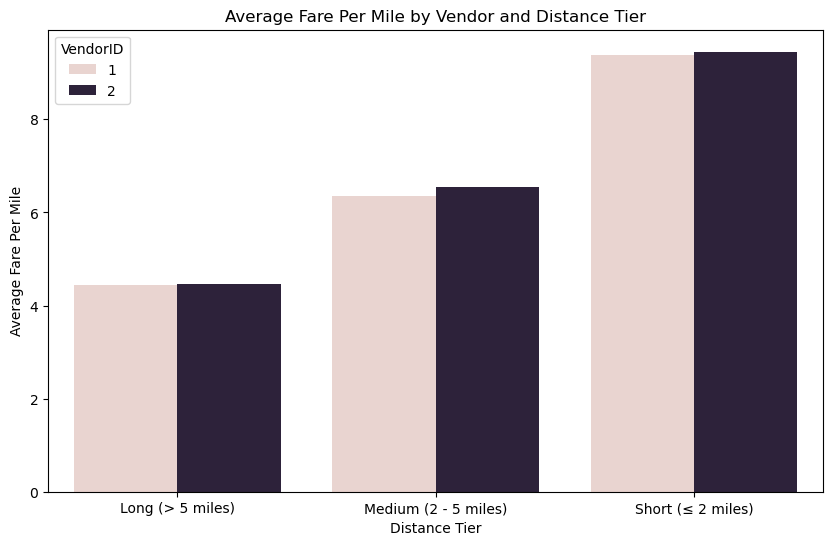

In [239]:
# Defining distance tiers

conditions = [
    (filtered_df['trip_distance'] <= 2),  
    (filtered_df['trip_distance'] > 2) & (filtered_df['trip_distance'] <= 5),  
    (filtered_df['trip_distance'] > 5)  
]
choices = ['Short (≤ 2 miles)', 'Medium (2 - 5 miles)', 'Long (> 5 miles)']

filtered_df['distance_tier'] = np.select(conditions, choices, default='Unknown')

vendor_fare_tiers = (
    filtered_df.groupby(['VendorID', 'distance_tier'])['fare_per_mile']
    .mean()
    .reset_index()
    .rename(columns={'fare_per_mile': 'avg_fare_per_mile'})
)

print("Average Fare Per Mile by Vendor and Distance Category:\n\n", vendor_fare_tiers,"\n")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=vendor_fare_tiers, x='distance_tier', y='avg_fare_per_mile', hue='VendorID')
plt.title('Average Fare Per Mile by Vendor and Distance Tier')
plt.xlabel('Distance Tier')
plt.ylabel('Average Fare Per Mile')
plt.legend(title='VendorID')
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

   passenger_category         pickup_time_category         distance_tier  \
0               Group     Afternoon (10 AM - 4 PM)      Long (> 5 miles)   
1               Group     Afternoon (10 AM - 4 PM)      Long (> 5 miles)   
2               Group     Afternoon (10 AM - 4 PM)  Medium (2 - 5 miles)   
3               Group     Afternoon (10 AM - 4 PM)  Medium (2 - 5 miles)   
4               Group     Afternoon (10 AM - 4 PM)     Short (≤ 2 miles)   
5               Group     Afternoon (10 AM - 4 PM)     Short (≤ 2 miles)   
6               Group        Evening (4 PM - 8 PM)      Long (> 5 miles)   
7               Group        Evening (4 PM - 8 PM)      Long (> 5 miles)   
8               Group        Evening (4 PM - 8 PM)  Medium (2 - 5 miles)   
9               Group        Evening (4 PM - 8 PM)  Medium (2 - 5 miles)   
10              Group        Evening (4 PM - 8 PM)     Short (≤ 2 miles)   
11              Group        Evening (4 PM - 8 PM)     Short (≤ 2 miles)   
12          

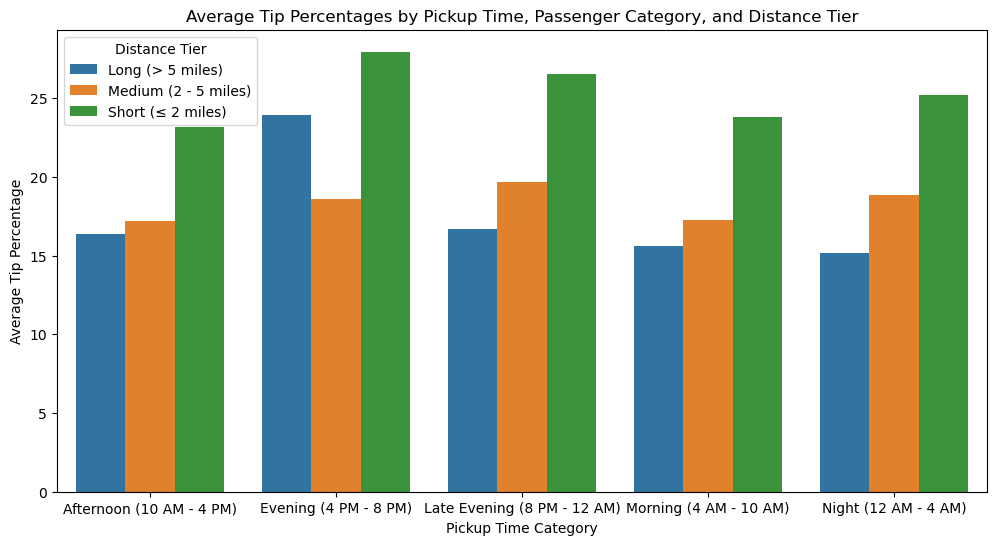

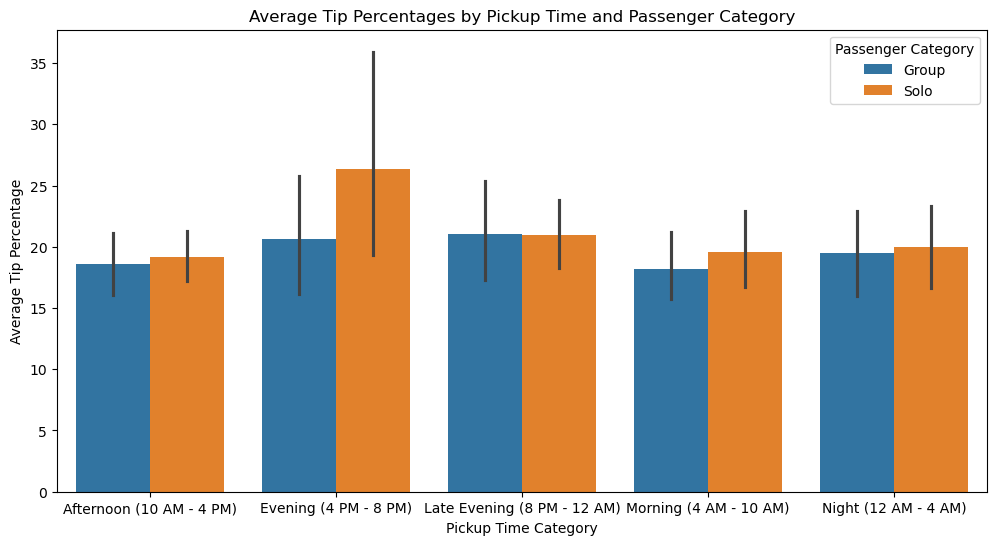

In [243]:
#  Analyze tip percentages based on distances, passenger counts and pickup times

filtered_df = filtered_df[filtered_df['fare_amount'] > 0]

def categorize_pickup_time(hour):
    if 4 <= hour < 10:
        return 'Morning (4 AM - 10 AM)'
    elif 10 <= hour < 16:
        return 'Afternoon (10 AM - 4 PM)'
    elif 16 <= hour < 20:
        return 'Evening (4 PM - 8 PM)'
    elif 20 <= hour < 24:
        return 'Late Evening (8 PM - 12 AM)'
    else:
        return 'Night (12 AM - 4 AM)'

filtered_df['tip_percentage'] = (filtered_df['tip_amount'] / filtered_df['fare_amount']) * 100
filtered_df['passenger_category'] = np.where(filtered_df['passenger_count'] > 1, 'Group', 'Solo')
filtered_df['pickup_time_category'] = filtered_df['pickup_hour'].apply(categorize_pickup_time)
filtered_df['day_type'] = filtered_df['pickup_day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Create a single table grouping by passenger count, pickup hour, day of the week, and distance tier
tip_analysis = (
    filtered_df.groupby(['passenger_category', 'pickup_time_category', 'distance_tier', 'day_type'])['tip_percentage']
    .mean()
    .reset_index()
    .sort_values(by=['passenger_category', 'pickup_time_category', 'distance_tier', 'day_type'])
)

# Display the result
print(tip_analysis)

# Plotting the bar chart with distance_tier included
plt.figure(figsize=(12, 6))
sns.barplot(data=tip_analysis, x='pickup_time_category', y='tip_percentage', hue='distance_tier', ci=None)
plt.title('Average Tip Percentages by Pickup Time, Passenger Category, and Distance Tier')
plt.xlabel('Pickup Time Category')
plt.ylabel('Average Tip Percentage')
plt.legend(title='Distance Tier')
plt.show()

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=tip_analysis, x='pickup_time_category', y='tip_percentage', hue='passenger_category')
plt.title('Average Tip Percentages by Pickup Time and Passenger Category')
plt.xlabel('Pickup Time Category')
plt.ylabel('Average Tip Percentage')
plt.legend(title='Passenger Category')
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

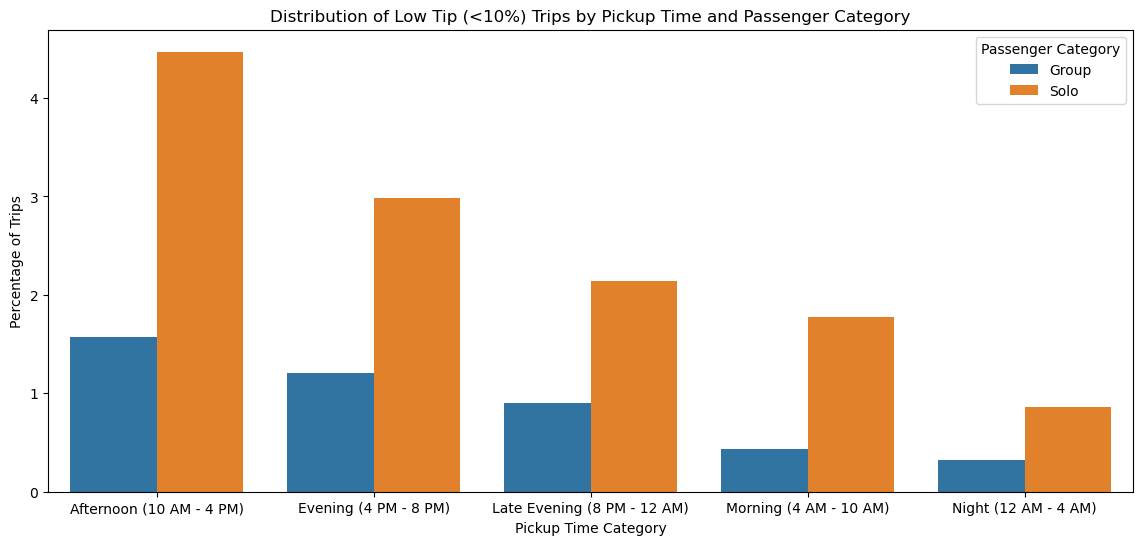

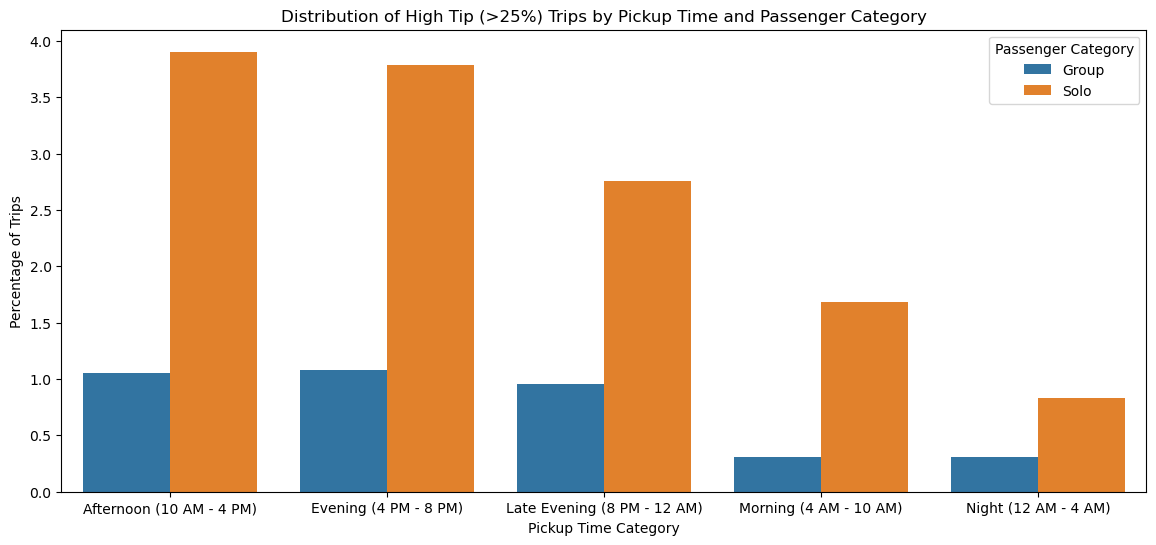

In [246]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%

# Filter trips with tip percentage < 10% and > 25%
low_tip_df = filtered_df[filtered_df['tip_percentage'] < 10]
high_tip_df = filtered_df[filtered_df['tip_percentage'] > 25]

# Group by key categories and calculate distributions
low_tip_summary = low_tip_df.groupby(['passenger_category', 'pickup_time_category', 'distance_tier', 'day_type']).size().reset_index(name='count')
high_tip_summary = high_tip_df.groupby(['passenger_category', 'pickup_time_category', 'distance_tier', 'day_type']).size().reset_index(name='count')

# Normalize counts to compare distributions
low_tip_summary['percentage'] = (low_tip_summary['count'] / low_tip_summary['count'].sum()) * 100
high_tip_summary['percentage'] = (high_tip_summary['count'] / high_tip_summary['count'].sum()) * 100

# Merge low and high tip summaries for comparison
comparison_df = low_tip_summary.merge(high_tip_summary, on=['passenger_category', 'pickup_time_category', 'distance_tier', 'day_type'], suffixes=('_low_tip', '_high_tip'))

# Plot comparison of trip characteristics
plt.figure(figsize=(14, 6))
sns.barplot(data=comparison_df, x='pickup_time_category', y='percentage_low_tip', hue='passenger_category', ci=None)
plt.title('Distribution of Low Tip (<10%) Trips by Pickup Time and Passenger Category')
plt.xlabel('Pickup Time Category')
plt.ylabel('Percentage of Trips')
plt.legend(title='Passenger Category')
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=comparison_df, x='pickup_time_category', y='percentage_high_tip', hue='passenger_category', ci=None)
plt.title('Distribution of High Tip (>25%) Trips by Pickup Time and Passenger Category')
plt.xlabel('Pickup Time Category')
plt.ylabel('Percentage of Trips')
plt.legend(title='Passenger Category')
plt.show()

Comparison of Low Tip (<10%) vs. High Tip (>25%) Trips:

- Solo Riders vs. Groups:

    1. Solo riders dominate both low-tip and high-tip categories.

    2. Groups have a smaller share in both cases, but slightly higher in high-tip trips.

- Pickup Time Trends:

    1. Low-tip trips: More frequent in the afternoon (10 AM - 4 PM) and evening (4 PM - 8 PM).

    2. High-tip trips: Also peak in the afternoon and evening but have a more balanced distribution across other time slots.

- Night & Late Evening Trends:

    1. Both low-tip and high-tip trips are lower during night hours (12 AM - 4 AM).

    2. Late evening (8 PM - 12 AM) sees a higher share of high tips.

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

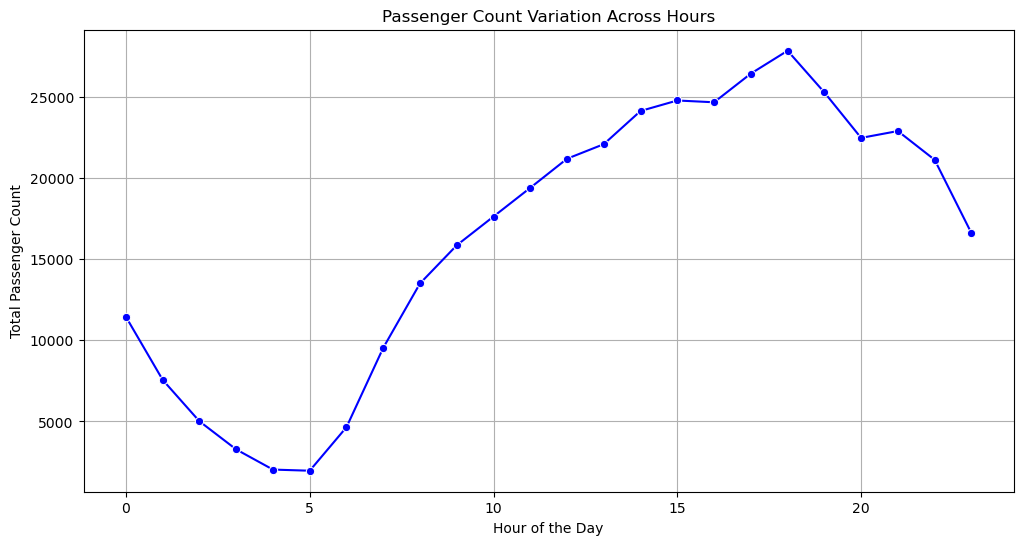

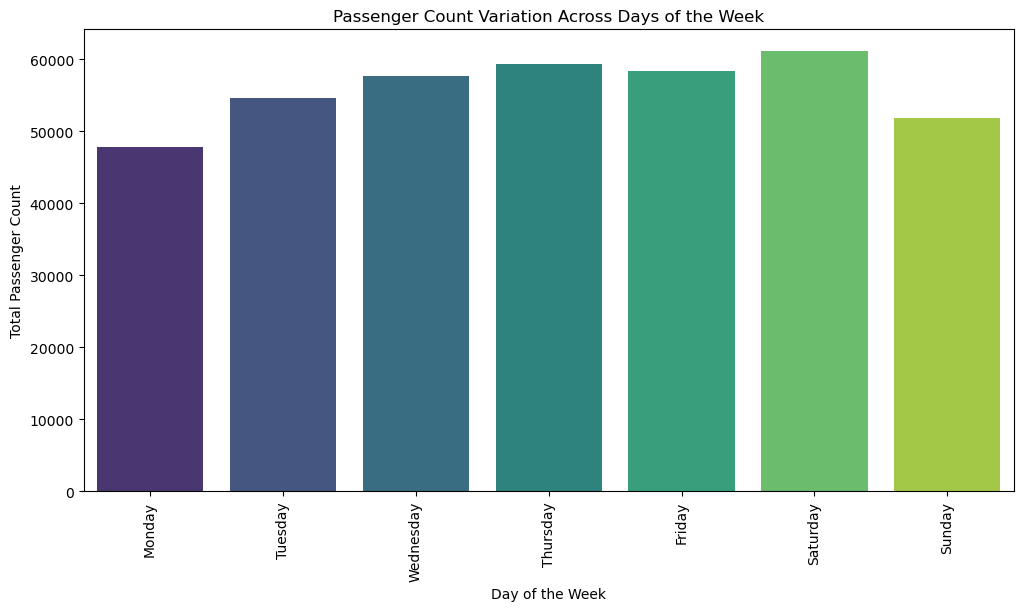

In [250]:
# See how passenger count varies across hours and days

hourly_passenger_count = filtered_df.groupby('pickup_hour')['passenger_count'].sum().reset_index()
daily_passenger_count = filtered_df.groupby('pickup_day_of_week')['passenger_count'].sum().reset_index()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_passenger_count['pickup_day_of_week'] = pd.Categorical(daily_passenger_count['pickup_day_of_week'], categories=day_order, ordered=True)
daily_passenger_count = daily_passenger_count.sort_values('pickup_day_of_week')

# Plot passenger count variation by hour
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_passenger_count, x='pickup_hour', y='passenger_count', marker='o', color='b')
plt.title('Passenger Count Variation Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Passenger Count')
plt.grid(True)
plt.show()

# Plot passenger count variation by day
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_passenger_count, x='pickup_day_of_week', y='passenger_count', palette='viridis')
plt.title('Passenger Count Variation Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Passenger Count')
plt.xticks(rotation=90)
plt.show()

# Create a heatmap of passenger count by hour and day
heatmap_data = filtered_df.pivot_table(index='pickup_day_of_week', columns='pickup_hour', values='passenger_count', aggfunc='sum')
heatmap_data = heatmap_data.reindex(day_order)

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5, annot=True, fmt='.0f', annot_kws={"size": 7})
plt.title('Passenger Count Heatmap: Hour vs Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [253]:
# How does passenger count vary across zones

passenger_df = filtered_df.groupby("PULocationID")["passenger_count"].agg(
    total_passenger_count="sum", avg_passenger_count="mean"
).reset_index()

passenger_df = passenger_df.sort_values(by="total_passenger_count", ascending=False)

passenger_df.head(10)

PULocationID  total_passenger_count  avg_passenger_count
89            132                22250.0             1.507963
111           161                18327.0             1.398687
171           237                17907.0             1.334252
170           236                16311.0             1.355410
165           230                14509.0             1.528389
94            138                13834.0             1.375559
112           162                13630.0             1.363409
131           186                13514.0             1.359831
97            142                13206.0             1.401316
120           170                11516.0             1.348478

Top 10 Total Passenger Count based on zones
   total_passenger_count  avg_passenger_count                          zone  \
0                22250.0             1.507963                   JFK Airport   
1                17907.0             1.334252         Upper East Side South   
2                18327.0             1.398687                Midtown Center   
3                16311.0             1.355410         Upper East Side North   
4                13834.0             1.375559             LaGuardia Airport   
5                13630.0             1.363409                  Midtown East   
6                13514.0             1.359831  Penn Station/Madison Sq West   
7                14509.0             1.528389     Times Sq/Theatre District   
8                13206.0             1.401316           Lincoln Square East   
9                11516.0             1.348478                   Murray Hill   

   LocationID  
0         132  
1         237  
2         161  
3         236  
4     

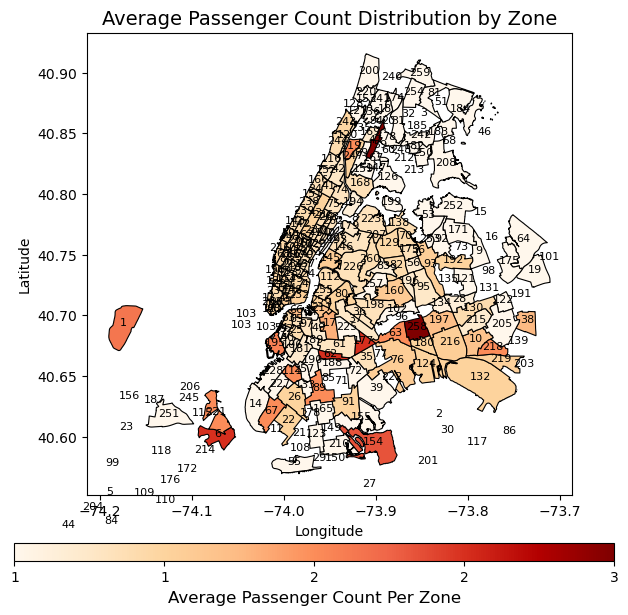

In [255]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.

zones_with_passenger_count = zones_with_trips.merge(passenger_df, left_on="LocationID", right_on="PULocationID", how="left")
zones_with_passenger_count.drop(columns=['PULocationID'], inplace=True)  

print("Top 10 Total Passenger Count based on zones")
print(zones_with_passenger_count[["total_passenger_count","avg_passenger_count","zone", "LocationID"]].head(10))

zones_with_passenger_count = zones_with_passenger_count.to_crs(epsg=4326)
zones_with_passenger_count["centroid"] = zones_with_passenger_count.geometry.centroid

# Colormap
cmap = cm.OrRd
vmin, vmax = zones_with_passenger_count["avg_passenger_count"].min(), zones_with_passenger_count["avg_passenger_count"].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot the map
zones_with_passenger_count.plot(
    column="avg_passenger_count", cmap=cmap, linewidth=0.8, edgecolor="black", ax=ax
)


# Add zone names at centroid locations
for idx, row in zones_with_passenger_count.iterrows():
    plt.text(
        row["centroid"].x, row["centroid"].y, 
        row["LocationID"],  # Assuming 'Zone' column has the zone names
        fontsize=8, color="black", ha="center"
    )

# Add colorbar
cbar_ax = fig.add_axes([0.25, 0.00, 0.5, 0.03])  # Adjust (left, bottom, width, height)
cb = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(cb, cax=cbar_ax, orientation="horizontal")

# Set colorbar ticks
tick_values = np.linspace(vmin, vmax, num=5)
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f"{int(val)}" for val in tick_values])  # Convert to integers

# Add colorbar title
cbar.set_label("Average Passenger Count Per Zone", fontsize=12)

# Labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Average Passenger Count Distribution by Zone", fontsize=14)

plt.show()

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

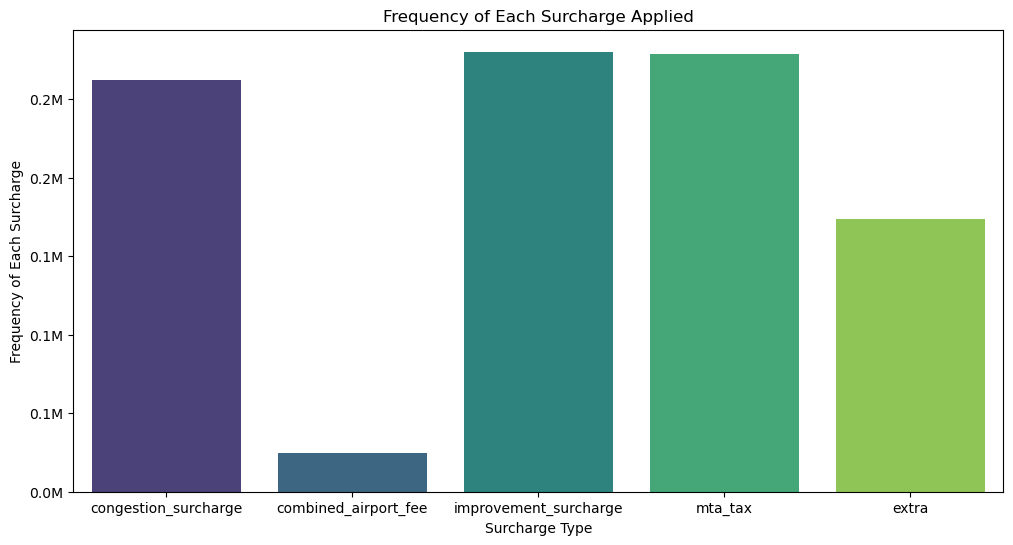

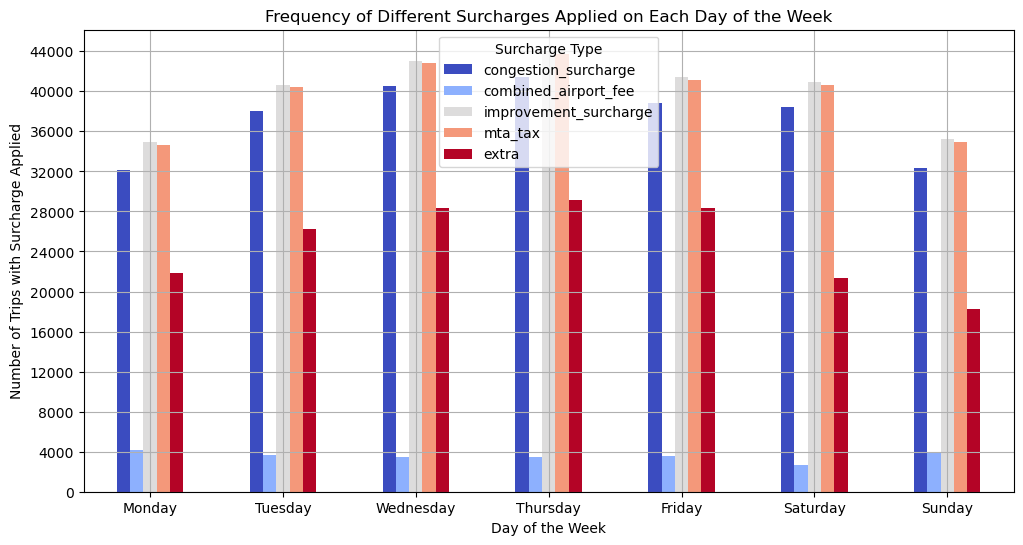

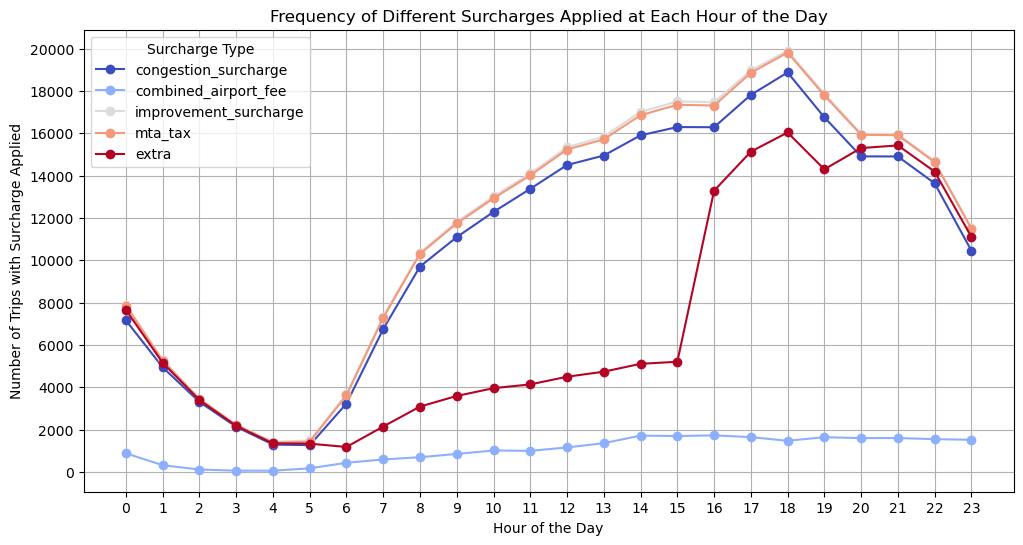

In [259]:
# How often is each surcharge applied?

import matplotlib.ticker as mtick

surcharge_counts = (filtered_df[['congestion_surcharge', 'combined_airport_fee', 'improvement_surcharge', 'mta_tax', 'extra']] > 0).sum()

# Plotting the frequency of surcharges
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=surcharge_counts, palette='viridis')
sns.barplot(data=surcharge_counts, palette='viridis')
plt.title('Frequency of Each Surcharge Applied')
plt.xlabel('Surcharge Type')
plt.ylabel('Frequency of Each Surcharge')
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.show()

weekly_surcharge_frequency = filtered_df.groupby("pickup_day_of_week")[[
    "congestion_surcharge", "combined_airport_fee", 
    "improvement_surcharge", "mta_tax", "extra"
]].apply(lambda x: (x > 0).sum())

y_max = weekly_surcharge_frequency.values.max()
step_size = round(y_max / 10, -3) if y_max > 10000 else round(y_max / 10, -2)  # Adjust step rounding
y_ticks = np.arange(0, y_max + step_size, step_size)  # Generate tick positions

# Plot the weekly variation
weekly_surcharge_frequency = weekly_surcharge_frequency.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
weekly_surcharge_frequency.plot(kind="bar", colormap="coolwarm", figsize=(12, 6))
plt.title("Frequency of Different Surcharges Applied on Each Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Trips with Surcharge Applied")
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=0)
plt.yticks(y_ticks)  
plt.legend(title="Surcharge Type")
plt.grid(True)
plt.show()
print()


hourly_surcharge_frequency = filtered_df.groupby("pickup_hour")[[
    "congestion_surcharge", "combined_airport_fee", 
    "improvement_surcharge", "mta_tax", "extra"
]].apply(lambda x: (x > 0).sum())

y_max = hourly_surcharge_frequency.values.max()
step_size = round(y_max / 10, -3)  # Dividing into 10 steps, rounding to nearest 1000
y_ticks = np.arange(0, y_max + step_size, step_size)  
# Plot the hourly variation
hourly_surcharge_frequency.plot(kind="line", marker="o", colormap="coolwarm", figsize=(12, 6))
plt.title("Frequency of Different Surcharges Applied at Each Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips with Surcharge Applied")
plt.xticks(range(24))
plt.yticks(y_ticks)  
plt.legend(title="Surcharge Type")
plt.grid(True)
plt.show()

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

AI-Driven Dispatching: Use real-time demand forecasting for efficient taxi allocation.

Reduce Inefficiencies: Minimize deadhead miles, optimize routes, and encourage ride pooling.

Demand-Based Fleet Allocation: Deploy more cabs near business hubs during peak hours and nightlife zones at night.

Smart Route Optimization: Use real-time traffic data and GPS to avoid congestion and reduce costs.

Event & Weather-Based Adjustments: Increase cab supply near transit hubs during bad weather and major events.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

Zone-Based Allocation: Increase cab availability in high-demand areas like business districts, airports, and entertainment hubs during peak times.

Dynamic Heatmap Deployment: Use real-time trip data to reposition cabs to emerging high-demand areas.
    
Time-Based Redistribution: Focus on residential areas in the morning, business districts in the afternoon, and nightlife zones in the evening.

Driver Incentives: Encourage movement to underserved areas through bonuses and geofencing alerts.
    
Event & Weather-Based Adjustments: Boost cab presence near stadiums, transit hubs, and key locations during special events and bad weather.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

Dynamic Pricing: Adjust fares based on demand surges, peak hours, and trip distances to maximize revenue while staying competitive.
    
Competitive Benchmarking: Regularly compare pricing with competitors and adjust rates accordingly to maintain market share.
    
Off-Peak Discounts: Offer lower fares or ride incentives during slow hours to boost demand.
    
Event-Based Pricing: Implement temporary fare increases around major events, holidays, and weather-related demand spikes.
    
Subscription & Loyalty Programs: Introduce ride passes and discounts for frequent riders to encourage repeat business and customer retention.